In [ ]:
import os
import math
import random
from copy import deepcopy
import time
import json
from pathlib import Path
# ---- Numerical / ML ----
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# ---- Torch ----
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
# ---- Vision (TorchVision) ----
import torchvision
import torchvision.transforms as transforms
# ---- Image processing ----
from PIL import Image
# ---- Plotting ----
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from datetime import datetime
# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:

# ============================================================
# GLOBAL CONFIG (shared by both CLEAS-C and Proposed Method)
# ============================================================
CONFIG = {
    # ---- Task setup ----
    "num_tasks": 10,
    "task_splits": [list(range(i*10, (i+1)*10)) for i in range(10)],
    # ---- Controller ----
    "H": 50,
    "U": 1,
    "p": 0.30,
    "alpha": 0.002, # architecture complexity penalty
    # REMOVED: beta (no efficiency bonus - let accuracy handle it)
    "controller_hidden_dim": 128,
    "num_actions": 4, # drop, use, drop+extend, use+extend
    # UPDATED: Configurable ratio bounds
    "ratio_min": 0.5,
    "ratio_max": 0.8,
    "ratio_range": 0.3, # = ratio_max - ratio_min
    # ---- Hyper-network sizes ----
    "conv1_max": 128,
    "conv2_max": 128,
    "conv3_max": 128,
    "fc1_max": 256,
    "fc2_max": 128,
    # ---- Initial architecture ----
    "init_conv1": 16,
    "init_conv2": 16,
    "init_conv3": 16,
    "init_fc1": 256,
    "init_fc2": 128,
    "init_filter_sizes": [3, 3, 4],
    # ---- Training settings ----
    "epochs_task1": 40,
    "epochs_new_weights": 8,
    "batch_size": 64,
    "lr_task": 1e-3,
    "lr_controller": 7e-4,
    # ---- Proposed Method Specific ----
    "K_fixed_per_class": 5,
}
# ============================================================
# RANDOM SEED
# ============================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == "cuda":
        torch.cuda.manual_seed_all(seed)
set_seed(42)
# ============================================================
# ONE-HOT
# ============================================================
def one_hot(val, size):
    v = np.zeros(size, dtype=np.float32)
    v[val] = 1.0
    return v
# ============================================================
# LAYER ENCODING (for state s_j)
# ============================================================
def build_layer_index_encoding():
    layer_sizes = [
        CONFIG["conv1_max"],
        CONFIG["conv2_max"],
        CONFIG["conv3_max"],
        CONFIG["fc1_max"],
        CONFIG["fc2_max"]
    ]
    total = sum(layer_sizes)
    num_layers = len(layer_sizes)
    enc = np.zeros((total, num_layers), dtype=np.float32)
    idx = 0
    for L, size in enumerate(layer_sizes):
        for _ in range(size):
            enc[idx][L] = 1.0
            idx += 1
    return enc, layer_sizes, total
LAYER_ENCODING, LAYER_SIZES, TOTAL_NEURONS = build_layer_index_encoding()
# State dimension: num_actions + num_layers (4 + 5 = 9)
STATE_DIM = CONFIG["num_actions"] + len(LAYER_SIZES)
# ============================================================
# CHECKPOINT UTILITIES (Enhanced for comparison)
# ============================================================
def save_checkpoint(actions, states, filter_sizes, ratios, search_times, last_completed_task, method_name, checkpoint_dir):
    os.makedirs(checkpoint_dir, exist_ok=True)
    # Save progress
    progress = {'last_completed_task': last_completed_task, 'method': method_name}
    with open(Path(checkpoint_dir) / 'progress.json', 'w') as f:
        json.dump(progress, f)
    # Save per task
    for t in range(len(actions)):
        np.save(Path(checkpoint_dir) / f'actions_{t}.npy', actions[t])
        torch.save(states[t], Path(checkpoint_dir) / f'states_{t}.pth')
        np.save(Path(checkpoint_dir) / f'filter_sizes_{t}.npy', np.array(filter_sizes[t], dtype=np.int32))
        if ratios[t] is not None:
            np.save(Path(checkpoint_dir) / f'ratios_{t}.npy', np.array([ratios[t]]))
        np.save(Path(checkpoint_dir) / f'times_{t}.npy', np.array([search_times[t]]))
def load_checkpoint(checkpoint_dir):
    progress_path = Path(checkpoint_dir) / 'progress.json'
    if not progress_path.exists():
        return [], [], [], [], [], -1, None
    with open(progress_path, 'r') as f:
        progress = json.load(f)
    last_task = progress['last_completed_task']
    method_name = progress.get('method', 'unknown')
    actions = []
    states = []
    filter_sizes = []
    ratios = []
    search_times = []
    for t in range(last_task + 1):
        actions.append(np.load(Path(checkpoint_dir) / f'actions_{t}.npy'))
        states.append(torch.load(Path(checkpoint_dir) / f'states_{t}.pth', map_location=device))
        filter_sizes.append(np.load(Path(checkpoint_dir) / f'filter_sizes_{t}.npy').tolist())
        search_times.append(np.load(Path(checkpoint_dir) / f'times_{t}.npy')[0])
        ratios_path = Path(checkpoint_dir) / f'ratios_{t}.npy'
        if ratios_path.exists():
            ratios.append(np.load(ratios_path)[0])
        else:
            ratios.append(None)
    return actions, states, filter_sizes, ratios, search_times, last_task, method_name
# ============================================================
# PART 2 — DATASET + CIFAR-100 TASK SLICES
# ============================================================
class TaskDataset(Dataset):
    def __init__(self, imgs, labels, class_list, transform):
        self.data = []
        self.targets = []
        self.transform = transform
        for x, y in zip(imgs, labels):
            if y in class_list:
                self.data.append(x)
                self.targets.append(class_list.index(y))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])
        label = self.targets[idx]
        img = self.transform(img)
        return img, label
def prepare_cifar100_tasks():
    print("[CLEAS] Loading CIFAR-100 dataset...")
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_data = torchvision.datasets.CIFAR100(root="./data", train=True, download=True)
    test_data = torchvision.datasets.CIFAR100(root="./data", train=False, download=True)

    train_loaders = []
    val_loaders = []
    test_loaders = []
    full_train_subsets = [] # NEW: For proposed method

    for class_list in CONFIG["task_splits"]:
        full_task_dataset = TaskDataset(
            imgs=train_data.data, labels=train_data.targets,
            class_list=class_list, transform=transform_train
        )
        idxs = np.arange(len(full_task_dataset))
        np.random.shuffle(idxs)
        val_size = int(0.10 * len(idxs))
        val_indices = idxs[:val_size]
        train_indices = idxs[val_size:]

        train_subset = Subset(full_task_dataset, train_indices)
        val_subset = Subset(full_task_dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

        test_task_dataset = TaskDataset(
            imgs=test_data.data, labels=test_data.targets,
            class_list=class_list, transform=transform_test
        )
        test_loader = DataLoader(test_task_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
        test_loaders.append(test_loader)
        full_train_subsets.append(train_subset) # NEW: Store full training subset

    print("[CLEAS] CIFAR-100 tasks successfully prepared.")
    return train_loaders, val_loaders, test_loaders, full_train_subsets
# ============================================================
# PART 3 — TASK NETWORK (CLEAS-C) - UNCHANGED
# ============================================================
def embed_kernel(old_kernel, new_k):
    old_k = old_kernel.shape[-1]
    assert new_k == old_k + 1
    out_c, in_c = old_kernel.shape[:2]
    new_kernel = torch.zeros((out_c, in_c, new_k, new_k), device=old_kernel.device)
    start = new_k // 2 - old_k // 2
    new_kernel[:, :, start:start+old_k, start:start+old_k] = old_kernel
    for oc in range(out_c):
        for ic in range(in_c):
            for i in range(new_k):
                for j in range(new_k):
                    if new_kernel[oc,ic,i,j] == 0:
                        neigh = []
                        for di in [-1,0,1]:
                            for dj in [-1,0,1]:
                                ni, nj = i+di, j+dj
                                if (0 <= ni < new_k and 0 <= nj < new_k):
                                    val = new_kernel[oc,ic,ni,nj]
                                    if not torch.all(val == 0):
                                        neigh.append(val)
                        new_kernel[oc,ic,i,j] = torch.stack(neigh).mean() if neigh else 0.001
    return new_kernel
class CLEASC_TaskNetwork(nn.Module):
    def __init__(self, action_vec, prev_action_vec, prev_state_dict, prev_filter_sizes, task_id):
        super().__init__()
        self.action_vec = action_vec
        self.prev_action_vec = prev_action_vec
        self.prev_state = prev_state_dict
        self.prev_filter_sizes = prev_filter_sizes
        self.task_id = task_id
        self.base_sizes = CONFIG["init_filter_sizes"]
        self.filter_sizes = self._compute_filter_sizes()
        self.active = self._compute_active_units()
        self._build_network()
        if self.prev_state is not None:
            self._reuse_and_freeze()
    def _compute_filter_sizes(self):
        sizes = []
        idx = 0
        prev_sizes = self.prev_filter_sizes or self.base_sizes
        for layer_i, max_units in enumerate([CONFIG["conv1_max"], CONFIG["conv2_max"], CONFIG["conv3_max"]]):
            actions = self.action_vec[idx:idx+max_units]
            extend_votes = np.sum((actions == 2) | (actions == 3))
            if extend_votes > (max_units // 2):
                sizes.append(prev_sizes[layer_i] + 1)
            else:
                sizes.append(prev_sizes[layer_i])
            idx += max_units
        return sizes
    def _compute_active_units(self):
        active = []
        idx = 0
        for max_units in [CONFIG["conv1_max"], CONFIG["conv2_max"], CONFIG["conv3_max"]]:
            actions = self.action_vec[idx:idx+max_units]
            act = np.where((actions == 1) | (actions == 3))[0]
            if len(act) == 0:
                act = np.array([0], dtype=int)
            active.append(act)
            idx += max_units
        fc1_slice = self.action_vec[idx:idx+CONFIG["fc1_max"]]
        act_fc1 = np.where((fc1_slice == 1) | (fc1_slice == 3))[0]
        if len(act_fc1) == 0:
            act_fc1 = np.array([0], dtype=int)
        idx += CONFIG["fc1_max"]
        fc2_slice = self.action_vec[idx:idx+CONFIG["fc2_max"]]
        act_fc2 = np.where((fc2_slice == 1) | (fc2_slice == 3))[0]
        if len(act_fc2) == 0:
            act_fc2 = np.array([0], dtype=int)
        active.extend([act_fc1, act_fc2])
        return active
    def _build_network(self):
        a = self.active
        f = self.filter_sizes
        n1, n2, n3 = len(a[0]), len(a[1]), len(a[2])
        k1, k2, k3 = f
        self.conv1 = nn.Conv2d(3, n1, k1, padding=k1//2)
        self.conv2 = nn.Conv2d(n1, n2, k2, padding=k2//2)
        self.conv3 = nn.Conv2d(n2, n3, k3, padding=k3//2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        def conv_out_size(size, kernel, padding, stride=1):
            return (size + 2*padding - kernel) // stride + 1

        size = 32
        size = size // 2 # pool1
        size = size // 2 # pool2
        size = conv_out_size(size, k3, k3//2)
        self.flatten_dim = size * size * n3

        self.fc1 = nn.Linear(self.flatten_dim, len(a[3]))
        self.fc2 = nn.Linear(len(a[3]), len(a[4]))
        self.out_heads = nn.ModuleList([nn.Linear(len(a[4]), 10) for _ in range(CONFIG["num_tasks"])])
    def _reuse_and_freeze(self):
        old_act = self._prev_active_units() if self.prev_action_vec is not None else [None] * 5
        new_act = self.active

        self._reuse_conv(self.conv1, "conv1", self.prev_filter_sizes[0], self.filter_sizes[0], old_act[0], new_act[0])
        self._reuse_conv(self.conv2, "conv2", self.prev_filter_sizes[1], self.filter_sizes[1], old_act[1], new_act[1])
        self._reuse_conv(self.conv3, "conv3", self.prev_filter_sizes[2], self.filter_sizes[2], old_act[2], new_act[2])
        self._reuse_fc(self.fc1, "fc1", old_act[3], new_act[3])
        self._reuse_fc(self.fc2, "fc2", old_act[4], new_act[4])
    def _prev_active_units(self):
        if self.prev_action_vec is None:
            return [None] * 5
        active = []
        idx = 0
        for max_units in [CONFIG["conv1_max"], CONFIG["conv2_max"], CONFIG["conv3_max"]]:
            slice_prev = self.prev_action_vec[idx:idx+max_units]
            act = np.where((slice_prev == 1) | (slice_prev == 3))[0]
            active.append(act)
            idx += max_units
        prev_fc1 = self.prev_action_vec[idx:idx+CONFIG["fc1_max"]]
        act_fc1 = np.where((prev_fc1 == 1) | (prev_fc1 == 3))[0]
        idx += CONFIG["fc1_max"]
        prev_fc2 = self.prev_action_vec[idx:idx+CONFIG["fc2_max"]]
        act_fc2 = np.where((prev_fc2 == 1) | (prev_fc2 == 3))[0]
        active.extend([act_fc1, act_fc2])
        return active
    def _reuse_conv(self, new_layer, layer_name, old_filter_size, new_filter_size, prev_active, new_active):
        if prev_active is None:
            return

        # previous weights/bias from saved state_dict (torch tensors)
        old_w_full = self.prev_state[f"{layer_name}.weight"]  # shape: (old_out, old_in, old_k, old_k)
        old_b_full = self.prev_state[f"{layer_name}.bias"]    # shape: (old_out,)

        new_w = new_layer.weight.data    # shape: (new_out, new_in, new_k, new_k)
        new_b = new_layer.bias.data

        device_new = new_w.device

        old_out, old_in, old_k, _ = old_w_full.shape
        new_in = new_w.shape[1]
        # iterate over new active output channels (local indices) and map from prev_active
        for new_local_idx, global_idx in enumerate(new_active):
            # check if this global index existed in previous active list
            if global_idx in prev_active:
                # get old local index (position within previous active units)
                old_local_idx_arr = np.where(prev_active == global_idx)[0]
                if old_local_idx_arr.size == 0:
                    continue
                old_local_idx = int(old_local_idx_arr[0])

                # extract old per-output-channel kernel and bias
                # ensure we move it to the device of new weights
                w_old = old_w_full[old_local_idx].to(device_new)    # shape: (old_in, old_k, old_k)
                b_old = old_b_full[old_local_idx].to(device_new)

                # If kernel size increased, spatially embed / pad w_old to new_filter_size
                if new_filter_size != w_old.shape[-1]:
                    # pad evenly (left/right, top/bottom)
                    old_k_sz = w_old.shape[-1]
                    new_k_sz = new_filter_size
                    left = (new_k_sz - old_k_sz) // 2
                    right = new_k_sz - old_k_sz - left
                    # pad expects (pad_w_left, pad_w_right, pad_h_left, pad_h_right)
                    w_old = F.pad(w_old, (left, right, left, right), mode='constant', value=0.0)

                # Now handle input-channel mismatch
                # w_old.shape -> (old_in, new_k, new_k)
                ch_old = w_old.shape[0]
                ch_new = new_in
                mapped = torch.zeros((ch_new, new_filter_size, new_filter_size), device=device_new)

                # copy min channels
                shared_ch = min(ch_old, ch_new)
                if shared_ch > 0:
                    mapped[:shared_ch] = w_old[:shared_ch]

                # if new has extra input channels, fill them with the mean over existing input kernels
                if ch_new > ch_old:
                    if ch_old > 0:
                        filler = w_old.mean(dim=0)  # shape (k,k)
                    else:
                        filler = torch.zeros((new_filter_size, new_filter_size), device=device_new)
                    mapped[ch_old:] = filler.unsqueeze(0).expand(ch_new - ch_old, -1, -1)

                # assign mapped into new_w slice
                new_w[new_local_idx] = mapped
    def _reuse_fc(self, new_layer, layer_name, prev_active, new_active):
        if prev_active is None:
            return
        old_w = self.prev_state[f"{layer_name}.weight"]
        old_b = self.prev_state[f"{layer_name}.bias"]
        new_w = new_layer.weight.data
        new_b = new_layer.bias.data
        old_in = old_w.shape[1]
        new_in = new_w.shape[1]
        for new_idx, global_idx in enumerate(new_active):
            if global_idx in prev_active:
                old_idx = np.where(prev_active == global_idx)[0][0]
                if old_in == new_in:
                    new_w[new_idx] = old_w[old_idx]
                    new_b[new_idx] = old_b[old_idx]
                    new_layer.weight.requires_grad = False
                    new_layer.bias.requires_grad = False
    def forward(self, x, task_id):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out_heads[task_id](x)
    def get_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
# ============================================================
# PART 4 — CONTROLLERS (UPDATED: Joint optimization for proposed method)
# ============================================================
# (A) ControllerLSTM — CLEAS-C (paper method) - UNCHANGED
class ControllerLSTM(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, num_actions=4):
        super().__init__()
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.num_actions = num_actions
        self.lstm = nn.LSTM(input_size=state_dim, hidden_size=hidden_dim, num_layers=1, batch_first=False)
        self.action_head = nn.Linear(hidden_dim, num_actions)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, state_seq):
        h = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        c = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        probs_list = []
        for j in range(state_seq.size(0)):
            s_j = state_seq[j].view(1, 1, -1)
            _, (h, c) = self.lstm(s_j, (h, c))
            logits = self.action_head(h.squeeze(0))
            probs = self.softmax(logits)
            probs_list.append(probs)
        return torch.cat(probs_list, dim=0)
    def select_actions(self, state_seq):
        probs = self.forward(state_seq)
        actions = torch.argmax(probs, dim=1)
        return actions.cpu().numpy(), probs
    def log_prob(self, probs, actions):
        selected = probs[torch.arange(len(actions)), actions]
        return torch.sum(torch.log(selected + 1e-8))
# (B) UPDATED ControllerLSTM_WithRatio — JOINT OPTIMIZATION
class ControllerLSTM_WithRatio(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, num_actions=4):
        super().__init__()
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.num_actions = num_actions
        self.lstm = nn.LSTM(input_size=state_dim, hidden_size=hidden_dim, num_layers=1, batch_first=False)
        self.action_head = nn.Linear(hidden_dim, num_actions)
        self.softmax = nn.Softmax(dim=-1)
        # UPDATED: Global data ratio prediction from final h_T
        self.ratio_head = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, state_seq):
        h = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        c = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        probs_list = []
        for j in range(state_seq.size(0)):
            s_j = state_seq[j].view(1, 1, -1)
            _, (h, c) = self.lstm(s_j, (h, c))
            # FIXED: Use per-step h for action probs
            h_j = h.squeeze(0)
            logits = self.action_head(h_j)
            probs = self.softmax(logits)
            probs_list.append(probs)
        # Final h for ratio
        final_h = h.squeeze(0)
        # UPDATED: Proper ratio prediction with configurable bounds
        raw = self.sigmoid(self.ratio_head(final_h))
        ratio = CONFIG["ratio_min"] + CONFIG["ratio_range"] * raw
        return torch.cat(probs_list, dim=0), ratio
    def select_actions(self, state_seq):
        probs, ratio = self.forward(state_seq)
        actions = torch.argmax(probs, dim=1)
        return actions.cpu().numpy(), probs, ratio.item()
    # CRITICAL FIX: JOINT log_prob for actions + ratio (improved: Beta-like skew for low ratios)
    def log_prob(self, probs, actions, ratio):
        # Action probabilities (unchanged)
        selected = probs[torch.arange(len(actions)), actions]
        action_log_prob = torch.sum(torch.log(selected + 1e-8))

        # --- Ratio log-prob using Beta(α, β) on normalized u in (0,1) ---
        # Use tensors on the same device as `ratio`
        device = ratio.device if isinstance(ratio, torch.Tensor) else torch.device('cpu')
        alpha = torch.tensor(2.0, device=device)
        beta_param = torch.tensor(5.0, device=device)

        # Normalize ratio to u in (0,1)
        u = (ratio - CONFIG["ratio_min"]) / (CONFIG["ratio_range"] + 1e-12)
        # Clamp to avoid log(0)
        eps = 1e-8
        u_clamped = torch.clamp(u, eps, 1.0 - eps)

        # Log Beta normalization constant: log B(alpha, beta)
        log_B = torch.lgamma(alpha) + torch.lgamma(beta_param) - torch.lgamma(alpha + beta_param)

        ratio_log_prob = (alpha - 1.0) * torch.log(u_clamped) + \
                         (beta_param - 1.0) * torch.log(1.0 - u_clamped) - log_B

        # If ratio is a scalar tensor, ratio_log_prob is scalar; sum to match action_log_prob shape
        if ratio_log_prob.dim() > 0:
            ratio_log_prob = ratio_log_prob.sum()

        return action_log_prob + ratio_log_prob

# ============================================================
# PART 5 — REPRESENTATIVE DATA SELECTOR (ROBUSTIFIED + DIVERSE)
# ============================================================
class RepresentativeDataSelector:
    def __init__(self, feature_extractor_model, full_train_dataset_subset, K_fixed_per_class=CONFIG["K_fixed_per_class"]):
        self.feature_extractor = feature_extractor_model
        self.full_train_dataset_subset = full_train_dataset_subset
        self.K_fixed_per_class = K_fixed_per_class
        self.X_features_cached = None
        self.Y_labels_cached = None
        self.internal_to_subset_indices_map = None
        self.class_kmeans_models = {}
        self.class_kmeans_labels = {}
        self._prepare_features_and_fixed_clusters()
    def _prepare_features_and_fixed_clusters(self):
        print("[Selector] Extracting features and performing fixed clustering...")
        self.feature_extractor.eval()

        feature_loader = DataLoader(self.full_train_dataset_subset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)
        X_features_list = []
        Y_labels_list = []
        internal_indices_in_subset_list = []

        with torch.no_grad():
            for batch_idx, (imgs, labels) in enumerate(feature_loader):
                imgs = imgs.to(device)
                feat = self.feature_extractor.get_features(imgs)
                X_features_list.append(feat.cpu().numpy())
                Y_labels_list.append(labels.cpu().numpy())
                current_batch_start_idx = batch_idx * CONFIG["batch_size"]
                current_batch_end_idx = min((batch_idx + 1) * CONFIG["batch_size"], len(self.full_train_dataset_subset))
                internal_indices_in_subset_list.extend(range(current_batch_start_idx, current_batch_end_idx))

        self.X_features_cached = np.vstack(X_features_list)
        self.Y_labels_cached = np.concatenate(Y_labels_list)
        self.internal_to_subset_indices_map = np.array(internal_indices_in_subset_list)

        classes = np.unique(self.Y_labels_cached)
        for cls in classes:
            class_indices_in_cached_features = np.where(self.Y_labels_cached == cls)[0]
            class_features = self.X_features_cached[class_indices_in_cached_features]

            n_samples_in_class = len(class_features)
            # FIXED: Robust K selection
            k_cls = min(self.K_fixed_per_class, max(1, n_samples_in_class // 2))
            if n_samples_in_class == 1:
                k_cls = 1

            kmeans = MiniBatchKMeans(n_clusters=k_cls, random_state=42, n_init=10)
            kmeans.fit(class_features)

            self.class_kmeans_models[cls] = kmeans
            self.class_kmeans_labels[cls] = kmeans.labels_

        print(f"[Selector] Fixed clustering complete: {len(self.class_kmeans_models)} classes, each with up to {self.K_fixed_per_class} clusters.")
    def select(self, data_ratio):
        selected_subset_indices = []
        classes = np.unique(self.Y_labels_cached)

        for cls in classes:
            if cls not in self.class_kmeans_models:
                # FIXED: Fallback for missing class
                class_indices_in_cached_features = np.where(self.Y_labels_cached == cls)[0]
                if len(class_indices_in_cached_features) > 0:
                    random_idx = np.random.choice(class_indices_in_cached_features)
                    subset_idx = self.internal_to_subset_indices_map[random_idx]
                    selected_subset_indices.append(subset_idx)
                continue

            kmeans_model = self.class_kmeans_models[cls]
            kmeans_labels_for_class = self.class_kmeans_labels[cls]
            class_indices_in_cached_features = np.where(self.Y_labels_cached == cls)[0]
            class_features = self.X_features_cached[class_indices_in_cached_features]
            n_samples_in_class = len(class_features)

            selected_for_class = []
            for cluster_id in range(kmeans_model.n_clusters):
                members_local_indices_in_class_features = np.where(kmeans_labels_for_class == cluster_id)[0]

                if len(members_local_indices_in_class_features) == 0:
                    continue

                num_to_select = max(1, int(len(members_local_indices_in_class_features) * data_ratio))
                num_to_select = min(num_to_select, len(members_local_indices_in_class_features))

                cluster_member_features = class_features[members_local_indices_in_class_features]
                centroid = kmeans_model.cluster_centers_[cluster_id]
                distances = np.linalg.norm(cluster_member_features - centroid, axis=1)
                sorted_indices_by_distance = np.argsort(distances)

                # FIXED: Restore diversity: 1 closest + farthest for remaining
                selected_local = [sorted_indices_by_distance[0]] # Closest (centroid rep)
                remaining = num_to_select - 1
                if remaining > 0:
                    farthest = sorted_indices_by_distance[-remaining:][::-1] # Farthest first
                    selected_local.extend(farthest)
                # If still short, random fill
                if len(selected_local) < num_to_select:
                    other = [i for i in range(len(sorted_indices_by_distance)) if i not in selected_local]
                    if other:
                        fill = np.random.choice(other, num_to_select - len(selected_local), replace=False)
                        selected_local.extend(fill)

                for local_idx in selected_local:
                    global_feature_idx = class_indices_in_cached_features[members_local_indices_in_class_features[local_idx]]
                    subset_idx = self.internal_to_subset_indices_map[global_feature_idx]
                    selected_for_class.append(subset_idx)

            # FIXED: Per-class fallback if none selected
            if not selected_for_class and n_samples_in_class > 0:
                random_idx_in_cached = np.random.choice(class_indices_in_cached_features)
                selected_for_class.append(self.internal_to_subset_indices_map[random_idx_in_cached])

            selected_subset_indices.extend(selected_for_class)

        return sorted(set(selected_subset_indices)) # Remove duplicates, sort
def get_representative_loader(full_train_subset, feature_extractor, data_ratio):
    selector = RepresentativeDataSelector(feature_extractor, full_train_subset)
    selected_indices = selector.select(data_ratio)
    representative_subset = Subset(full_train_subset, selected_indices)
    return DataLoader(representative_subset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2)
# ============================================================
# PART 6 — UTILITIES & EVALUATION
# ============================================================
def count_new_neurons(action_vec, prev_action_vec):
    if prev_action_vec is None:
        return int(((action_vec == 1) | (action_vec == 3)).sum())
    prev_inactive = (prev_action_vec == 0) | (prev_action_vec == 2)
    curr_active = (action_vec == 1) | (action_vec == 3)
    return int((prev_inactive & curr_active).sum())
def evaluate_on_all_tasks(model, test_loaders, current_task_id):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for t in range(current_task_id + 1):
            correct, total = 0, 0
            for imgs, labels in test_loaders[t]:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs, task_id=t).argmax(dim=1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)
            total_correct += correct
            total_samples += total
    return total_correct / total_samples if total_samples > 0 else 0.0
# UPDATED: SIMPLIFIED REWARD (No efficiency bonus)
def compute_reward(mean_all_acc, C_new, alpha=CONFIG["alpha"]):
    return mean_all_acc - alpha * C_new
# NEW: Evaluate all tasks for final accs
def evaluate_all_tasks(actions_list, states_list, filter_sizes_list, test_loaders):
    """
    Reconstruct each task model using the SAME chain of previous states/filter sizes that were
    used during training, then evaluate on that task's test_loader.
    Returns: list of accuracies (per-task) computed using the model saved for that task.
    """
    accs = []
    prev_action = None
    prev_state = None
    prev_filters = CONFIG["init_filter_sizes"]

    for t in range(len(actions_list)):
        # Build model exactly as it was when saved:
        model = CLEASC_TaskNetwork(
            action_vec=actions_list[t],
            prev_action_vec=prev_action,
            prev_state_dict=prev_state,
            prev_filter_sizes=prev_filters,
            task_id=t
        ).to(device)

        # load the saved state (states_list[t]) - map_location handled when saved earlier
        model.load_state_dict(states_list[t])
        model.eval()

        # evaluate on test loader for task t
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loaders[t]:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs, task_id=t).argmax(dim=1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)
        accs.append(correct / total if total > 0 else 0.0)

        # update previous pointers for next iteration
        prev_action = actions_list[t]
        prev_state = states_list[t]
        prev_filters = filter_sizes_list[t]

    return accs

# ============================================================
# PART 7 — TRAINING CANDIDATES (COMPARISON READY)
# ============================================================
def train_candidate(method, t, action_vec, prev_action_vec, prev_state_dict, prev_filter_sizes,
                   train_loader, val_loader, test_loaders, full_train_subset=None, data_ratio=None):
    """
    method: 'cleasc' or 'proposed'
    """
    start_time = time.time()

    # Build architecture
    model = CLEASC_TaskNetwork(
        action_vec=action_vec, prev_action_vec=prev_action_vec,
        prev_state_dict=prev_state_dict, prev_filter_sizes=prev_filter_sizes, task_id=t
    ).to(device)

    C_new = count_new_neurons(action_vec, prev_action_vec)

    # Select training loader
    if method == 'cleasc':
        training_loader = train_loader
    else:
        # PROPOSED: Use representative subset
        training_loader = get_representative_loader(full_train_subset, model, data_ratio)

    # Train only new weights
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=CONFIG["lr_task"])
    crit = nn.CrossEntropyLoss()
    model.train()

    for ep in range(CONFIG["epochs_new_weights"]):
        for imgs, labels in training_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs, task_id=t)
            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    # Validation accuracy
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs, task_id=t).argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    # Mean accuracy over all tasks (forgetting metric)
    mean_all_acc = evaluate_on_all_tasks(model, test_loaders, t)

    # SIMPLIFIED REWARD: No efficiency bonus
    reward = compute_reward(mean_all_acc, C_new)

    training_time = time.time() - start_time

    return model, val_acc, reward, model.filter_sizes, training_time
# ============================================================
# PART 8 — TASK 1 BASELINE TRAINING
# ============================================================
def train_task_1(train_loader, val_loader, test_loaders):
    print("\n================ TRAINING TASK 1 (BASELINE) ================\n")
    # Build initial action vector for Task 1 (activate first N units)
    actions = np.zeros(TOTAL_NEURONS, dtype=int)
    idx = 0
    for init_sz, max_sz in zip(
        [CONFIG["init_conv1"], CONFIG["init_conv2"], CONFIG["init_conv3"],
         CONFIG["init_fc1"], CONFIG["init_fc2"]],
        [
            CONFIG["conv1_max"],
            CONFIG["conv2_max"],
            CONFIG["conv3_max"],
            CONFIG["fc1_max"],
            CONFIG["fc2_max"]
        ]
    ):
        actions[idx:idx+init_sz] = 1 # set to "use"
        idx += max_sz
    model = CLEASC_TaskNetwork(
        action_vec=actions,
        prev_action_vec=None,
        prev_state_dict=None,
        prev_filter_sizes=None,
        task_id=0
    ).to(device)
    # Full training for Task 1
    opt = torch.optim.Adam(model.parameters(), lr=CONFIG["lr_task"])
    crit = torch.nn.CrossEntropyLoss()
    for ep in range(CONFIG["epochs_task1"]):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            opt.zero_grad()
            out = model(imgs, task_id=0)
            loss = crit(out, labels)
            loss.backward()
            opt.step()
        print(f"Task 1 Training Epoch {ep+1}/{CONFIG['epochs_task1']}")
    print("Task 1 training complete.\n")
    # Compute mean_all_acc for Task 1
    mean_all_acc = evaluate_on_all_tasks(model, test_loaders, 0)
    print(f"Task 1 Mean All Acc: {mean_all_acc:.4f}")
    # Return
    return actions, deepcopy(model.state_dict()), deepcopy(model.filter_sizes), 1.0, 0.0 # ratio=1.0, time=0
# ============================================================
# PART 9 — MAIN TRAINING LOOP (COMPARISON ENABLED + FIXED)
# ============================================================
def run_method(method_name, train_loaders, val_loaders, test_loaders, full_train_subsets, checkpoint_dir):
    """
    Runs either 'cleasc' or 'proposed' method
    Returns: actions, states, filter_sizes, ratios, search_times
    """
    print(f"[RUNNING] {method_name.upper()} on {CONFIG['num_tasks']} tasks...")

    # Load checkpoint if exists
    actions, states, filter_sizes, ratios, search_times, last_task, loaded_method = load_checkpoint(checkpoint_dir)
    if loaded_method and loaded_method != method_name:
        print(f"Warning: Checkpoint method mismatch. Starting fresh.")
        actions, states, filter_sizes, ratios, search_times, last_task = [], [], [], [], [], -1

    # FIXED: Correct state_dim
    if method_name == 'cleasc':
        controller = ControllerLSTM(STATE_DIM, CONFIG["controller_hidden_dim"], CONFIG["num_actions"])
    else:
        controller = ControllerLSTM_WithRatio(STATE_DIM, CONFIG["controller_hidden_dim"], CONFIG["num_actions"])

    controller = controller.to(device)
    # FIXED: Back to RMSprop for REINFORCE stability
    controller_optimizer = optim.RMSprop(controller.parameters(), lr=CONFIG["lr_controller"])

    if last_task < 0:
        # FIXED: Handle Task 1 baseline
        a1, s1, f1, r1, t1 = train_task_1(train_loaders[0], val_loaders[0], test_loaders)
        actions = [a1]
        states = [s1]
        filter_sizes = [f1]
        ratios = [r1]
        search_times = [t1]
        last_task = 0
        save_checkpoint(actions, states, filter_sizes, ratios, search_times, last_task, method_name, checkpoint_dir)

    prev_action_vec = actions[-1] if actions else None
    prev_state_dict = states[-1] if states else None
    prev_filter_sizes = filter_sizes[-1] if filter_sizes else CONFIG["init_filter_sizes"]

    for t in range(last_task + 1, CONFIG["num_tasks"]):
        print(f"\n--- Task {t} ({method_name}) ---")
        task_start_time = time.time()

        # FIXED: Correct state building (use prev actions for s_j)
        state_seq = build_state_from_actions(prev_action_vec) if prev_action_vec is not None else build_random_state()

        # Search loop (H episodes)
        best_reward = -float('inf')
        best_action_vec = None
        best_model = None
        best_filter_sizes = None
        best_ratio = None
        # FIXED: Track rewards for baseline
        episode_rewards = []



        # ... inside run_method(), replace the search loop with this:
        for h in range(CONFIG["H"]):
            # FIXED: Exploration
            if h == 0 or np.random.rand() < CONFIG["p"]:
                state_seq = build_random_state()

            controller.eval()
            with torch.no_grad():
                if method_name == 'cleasc':
                    actions_np, probs = controller.select_actions(state_seq)
                    data_ratio = None
                else:
                    actions_np, probs, data_ratio_val = controller.select_actions(state_seq)
                    data_ratio = data_ratio_val

            # Count new neurons for reporting (so we can print it per-episode)
            C_new = count_new_neurons(actions_np, prev_action_vec)

            # Train candidate architecture (capture candidate training time)
            candidate_model, val_acc, reward, candidate_filter_sizes, candidate_time = train_candidate(
                method_name, t, actions_np, prev_action_vec, prev_state_dict, prev_filter_sizes,
                train_loaders[t], val_loaders[t], test_loaders,
                full_train_subsets[t] if method_name == 'proposed' else None, data_ratio
            )

            episode_rewards.append(reward)

            # Update best if needed
            if reward > best_reward:
                best_reward = reward
                best_action_vec = actions_np.copy()
                best_model = candidate_model
                best_filter_sizes = candidate_filter_sizes
                best_ratio = data_ratio

            # === PER-EPISODE PRINT ===
            # wall-clock timestamp
            wall_clock = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            elapsed_since_task_start = time.time() - task_start_time
            # Print a compact per-episode line:
            print(f"[{wall_clock}] [Task {t}] [Episode {h+1}/{CONFIG['H']}] "
                  f"reward={reward:.4f} val_acc={val_acc:.4f} new_neurons={C_new} "
                  f"cand_time={candidate_time:.2f}s elapsed_task={elapsed_since_task_start:.2f}s "
                  f"ratio={'{:.3f}'.format(data_ratio) if data_ratio is not None else 'N/A'}")

            # REINFORCE update (unchanged)
            controller.train()
            controller_optimizer.zero_grad()
            probs.requires_grad_(True) # Ensure grads
            actions_t = torch.tensor(actions_np, dtype=torch.long, device=device)

            if method_name == 'cleasc':
                log_prob_val = controller.log_prob(probs, actions_t)
                advantage = reward - (np.mean(episode_rewards) if episode_rewards else 0)
                loss = -log_prob_val * advantage
            else:
                ratio_t = torch.tensor(data_ratio, device=device, requires_grad=True)
                log_prob_val = controller.log_prob(probs, actions_t, ratio_t)
                advantage = reward - (np.mean(episode_rewards) if episode_rewards else 0)
                loss = -log_prob_val * advantage

            loss.backward()
            torch.nn.utils.clip_grad_norm_(controller.parameters(), 0.5)
            controller_optimizer.step()

        # Update for next task
        actions.append(best_action_vec)
        states.append(best_model.state_dict())
        filter_sizes.append(best_filter_sizes)
        ratios.append(best_ratio)
        search_times.append(time.time() - task_start_time)

        prev_action_vec = best_action_vec
        prev_state_dict = deepcopy(best_model.state_dict())
        prev_filter_sizes = best_filter_sizes

        # Save checkpoint
        save_checkpoint(actions, states, filter_sizes, ratios, search_times, t, method_name, checkpoint_dir)

        print(f"Task {t}: Best reward={best_reward:.4f}, Val acc={val_acc:.4f}, "
              f"Mean all acc={best_reward + CONFIG['alpha']*count_new_neurons(best_action_vec, prev_action_vec):.4f}, "
              f"Time={search_times[-1]:.2f}s, Ratio={best_ratio if best_ratio else 'N/A'}")

    return actions, states, filter_sizes, ratios, search_times
# FIXED: Add missing build_state functions
def build_state_from_actions(action_vec):
    states = []
    for j in range(TOTAL_NEURONS):
        a = action_vec[j]
        a_oh = one_hot(a, CONFIG["num_actions"])
        layer_oh = LAYER_ENCODING[j]
        s_j = np.concatenate([a_oh, layer_oh])
        states.append(s_j)
    states = np.stack(states, axis=0)
    return torch.tensor(states, dtype=torch.float32).to(device)
def build_random_state():
    states = []
    for j in range(TOTAL_NEURONS):
        a = np.random.randint(0, CONFIG["num_actions"])
        a_oh = one_hot(a, CONFIG["num_actions"])
        layer_oh = LAYER_ENCODING[j]
        states.append(np.concatenate([a_oh, layer_oh]))
    return torch.tensor(np.stack(states), dtype=torch.float32).to(device)
# ============================================================
# NEW: Compute acc_matrix
# ============================================================
def compute_acc_matrix(actions, states, filter_sizes, test_loaders):
    acc_matrix = []
    prev_action = None
    prev_state = None
    prev_filters = CONFIG["init_filter_sizes"]
    for t in range(CONFIG["num_tasks"]):
        model = CLEASC_TaskNetwork(
            action_vec=actions[t],
            prev_action_vec=prev_action,
            prev_state_dict=prev_state,
            prev_filter_sizes=prev_filters,
            task_id=t
        ).to(device)
        model.load_state_dict(states[t])
        current_accs = []
        for i in range(t + 1):
            correct = 0
            total = 0
            model.eval()
            with torch.no_grad():
                for imgs, labels in test_loaders[i]:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs, task_id=i)
                    preds = outputs.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            current_accs.append(correct / total if total > 0 else 0.0)
        acc_matrix.append(current_accs)
        # Update prev
        prev_action = actions[t]
        prev_state = states[t]
        prev_filters = filter_sizes[t]
    return acc_matrix

# ============================================================
# NEW: Compute average forgetting
# ============================================================
def compute_average_forgetting(acc_matrix):
    num_tasks = len(acc_matrix)
    forgettings = []
    for i in range(num_tasks - 1):
        max_acc = max(acc_matrix[s][i] for s in range(i, num_tasks))
        final_acc = acc_matrix[-1][i]
        forgettings.append(max_acc - final_acc)
    return np.mean(forgettings) if forgettings else 0.0

# ============================================================
# NEW: Compute new neurons list
# ============================================================
def compute_new_neurons_list(actions):
    new_list = []
    for t in range(len(actions)):
        if t == 0:
            new = count_new_neurons(actions[0], None)
        else:
            new = count_new_neurons(actions[t], actions[t-1])
        new_list.append(new)
    return new_list



[CLEAS] Loading CIFAR-100 dataset...
[CLEAS] CIFAR-100 tasks successfully prepared.
[RUNNING] CLEASC on 10 tasks...
[RUNNING] PROPOSED on 10 tasks...

Per-Task Accuracy (Right After Learning):
Task	CLEAS-C	Proposed
0	0.7270	0.7250
1	0.5070	0.1480
2	0.4190	0.1290
3	0.4110	0.2050
4	0.4870	0.1780
5	0.5720	0.1250
6	0.6670	0.1930
7	0.6490	0.1510
8	0.6920	0.1540
9	0.7160	0.1670

Final Per-Task Accuracy (After All Tasks):
Task	CLEAS-C	Proposed
0	0.1400	0.0950
1	0.0990	0.1000
2	0.1130	0.0970
3	0.0970	0.1530
4	0.0950	0.0750
5	0.1490	0.1120
6	0.1270	0.1000
7	0.1130	0.1810
8	0.1340	0.1000
9	0.7160	0.1670

Forgetting Per Task:
Task	CLEAS-C	Proposed
0	0.5870	0.6300
1	0.4080	0.0480
2	0.3060	0.0790
3	0.3140	0.0520
4	0.3920	0.1050
5	0.4230	0.0130
6	0.5400	0.0930
7	0.5360	0.0000
8	0.5580	0.0540

COMPARISON RESULTS
Metric               CLEAS-C      Proposed     Improvement 
--------------------------------------------------------------------------------
Mean After-Learn Acc:  0.5847   0.2175    -62.8%
M

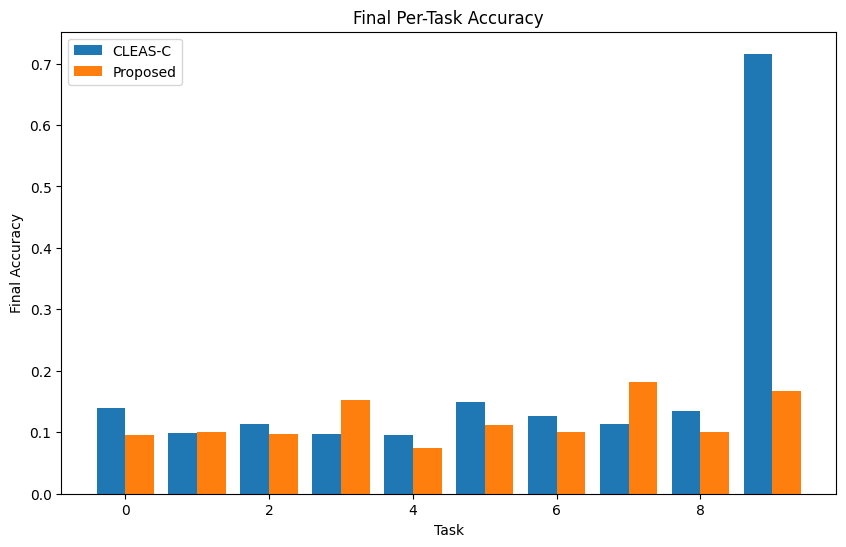

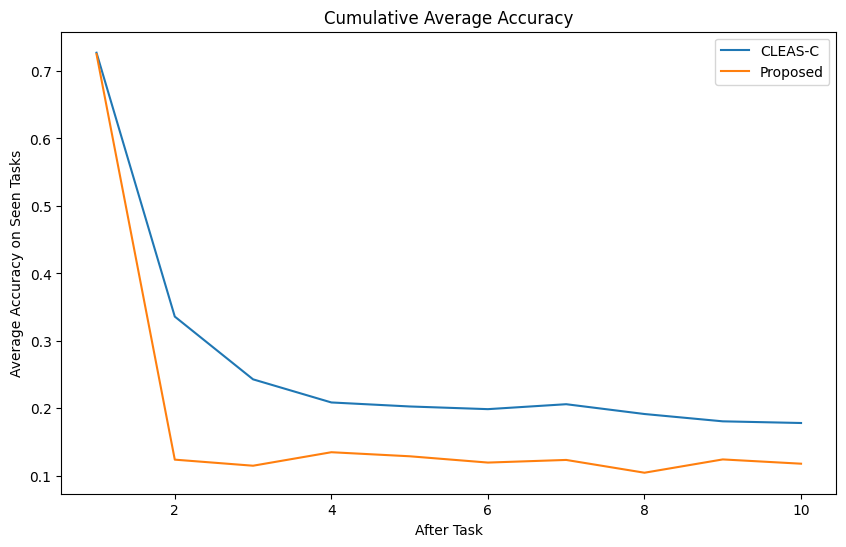

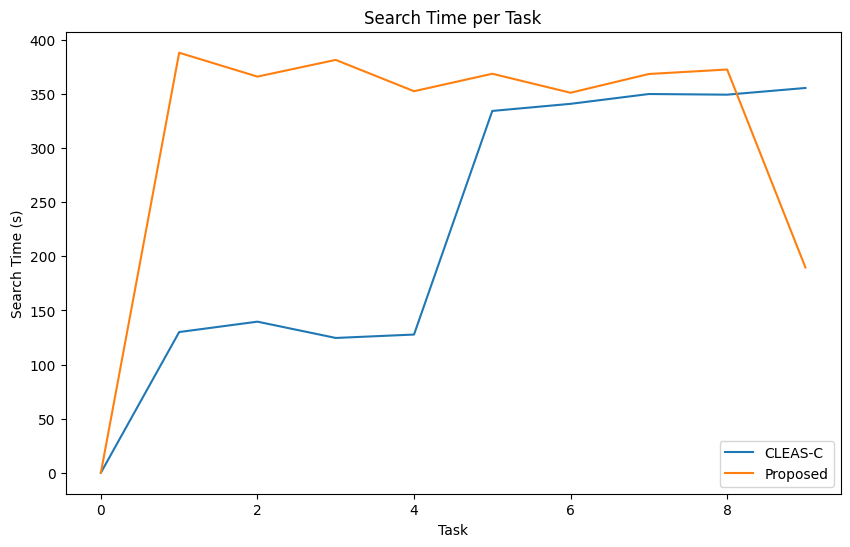

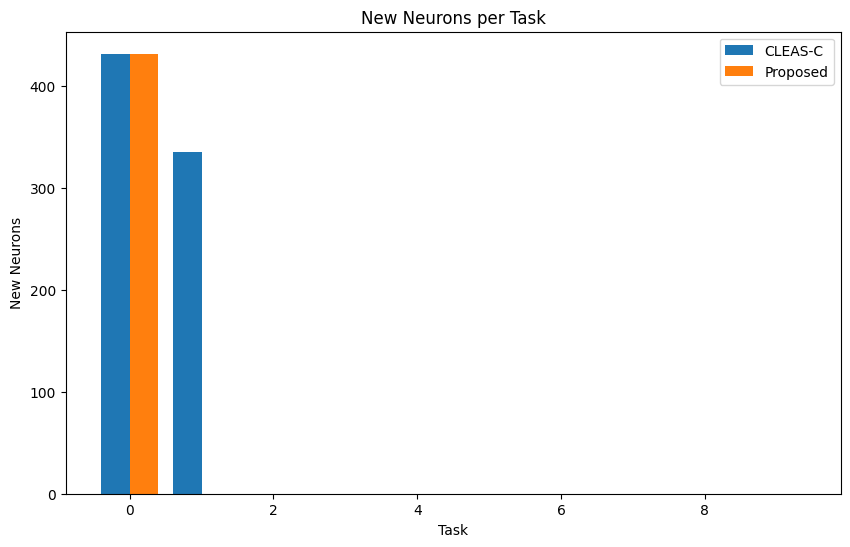

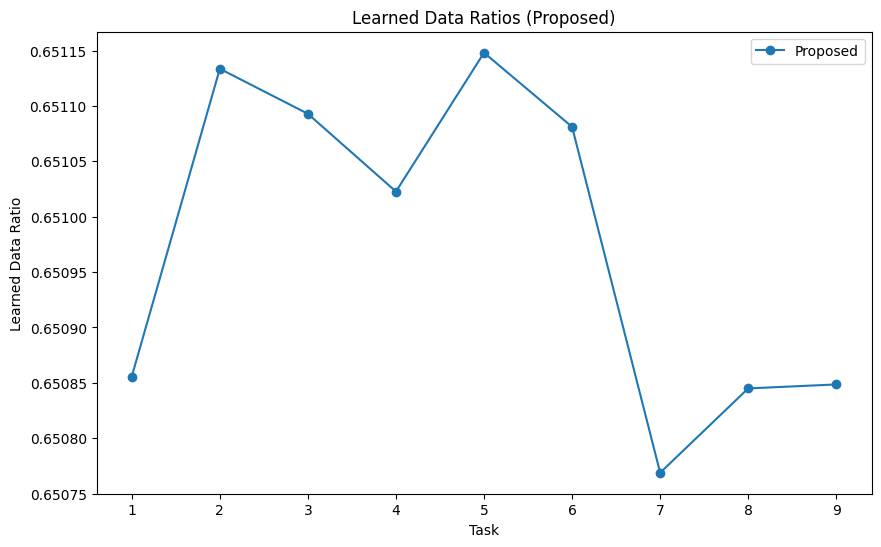

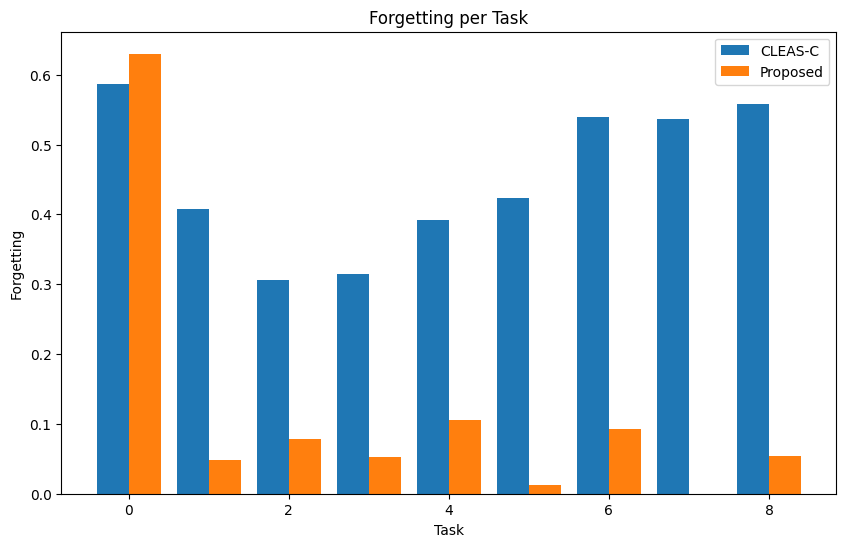


==================== DONE ====================



In [ ]:
# ============================================================
# PART 10 — COMPARATIVE EXPERIMENT RUNNER + ABLATIONS
# ============================================================
def run_full_comparison():
    train_loaders, val_loaders, test_loaders, full_train_subsets = prepare_cifar100_tasks()

    # Run both methods
    cleas_results = run_method('cleasc', train_loaders, val_loaders, test_loaders, full_train_subsets,
                              'checkpoints_cleasc')
    proposed_results = run_method('proposed', train_loaders, val_loaders, test_loaders, full_train_subsets,
                                 'checkpoints_proposed')
    cleas_after_learn_accs = evaluate_all_tasks(cleas_results[0], cleas_results[1], cleas_results[2], test_loaders)
    prop_after_learn_accs = evaluate_all_tasks(proposed_results[0], proposed_results[1], proposed_results[2], test_loaders)

    # Compute acc_matrix
    cleas_acc_matrix = compute_acc_matrix(cleas_results[0], cleas_results[1], cleas_results[2], test_loaders)
    proposed_acc_matrix = compute_acc_matrix(proposed_results[0], proposed_results[1], proposed_results[2], test_loaders)

    cleas_final_accs = cleas_acc_matrix[-1]
    prop_final_accs = proposed_acc_matrix[-1]

    cleas_forget = compute_average_forgetting(cleas_acc_matrix)
    prop_forget = compute_average_forgetting(proposed_acc_matrix)

    cleas_new_neurons = compute_new_neurons_list(cleas_results[0])
    prop_new_neurons = compute_new_neurons_list(proposed_results[0])

    # Print per-task after-learn accs
    print("\nPer-Task Accuracy (Right After Learning):")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"]):
        print(f"{t}\t{cleas_after_learn_accs[t]:.4f}\t{prop_after_learn_accs[t]:.4f}")

    # Print final per-task accs
    print("\nFinal Per-Task Accuracy (After All Tasks):")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"]):
        print(f"{t}\t{cleas_final_accs[t]:.4f}\t{prop_final_accs[t]:.4f}")

    # Print forgetting per task
    print("\nForgetting Per Task:")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"] - 1):
        cleas_max = max(cleas_acc_matrix[s][t] for s in range(t, CONFIG["num_tasks"]))
        prop_max = max(proposed_acc_matrix[s][t] for s in range(t, CONFIG["num_tasks"]))
        cleas_f = cleas_max - cleas_final_accs[t]
        prop_f = prop_max - prop_final_accs[t]
        print(f"{t}\t{cleas_f:.4f}\t{prop_f:.4f}")

    # Comparison metrics
    print("\n" + "="*80)
    print("COMPARISON RESULTS")
    print("="*80)
    print(f"{'Metric':<20} {'CLEAS-C':<12} {'Proposed':<12} {'Improvement':<12}")
    print("-"*80)
    cleas_times = np.array(cleas_results[4])
    prop_times = np.array(proposed_results[4])
    print(f"Mean After-Learn Acc:{np.mean(cleas_after_learn_accs):8.4f} {np.mean(prop_after_learn_accs):8.4f} "
          f"{100*(np.mean(prop_after_learn_accs)-np.mean(cleas_after_learn_accs))/np.mean(cleas_after_learn_accs):8.1f}%")
    print(f"Mean Final Acc:     {np.mean(cleas_final_accs):8.4f} {np.mean(prop_final_accs):8.4f} "
          f"{100*(np.mean(prop_final_accs)-np.mean(cleas_final_accs))/np.mean(cleas_final_accs):8.1f}%")
    print(f"Avg Forgetting:     {cleas_forget:8.4f} {prop_forget:8.4f} "
          f"{100*(1 - prop_forget/cleas_forget if cleas_forget != 0 else 0):8.1f}% reduction")
    print(f"Mean time/task:     {cleas_times.mean():8.2f}s {prop_times.mean():8.2f}s "
          f"{100*(1-prop_times.mean()/cleas_times.mean()):8.1f}%")
    print(f"Total time:         {cleas_times.sum():8.2f}s {prop_times.sum():8.2f}s "
          f"{100*(1-prop_times.sum()/cleas_times.sum()):8.1f}%")

    # Theoretical note (as comment)
    print("\nTheoretical: Proposed saves ~ (1 - avg_ratio) * H * train_time/episode, minus ~15s overhead/task.")

    # Graphs
    tasks = list(range(CONFIG["num_tasks"]))

    # Final per-task acc
    plt.figure(figsize=(10, 6))
    plt.bar([t - 0.2 for t in tasks], cleas_final_accs, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in tasks], prop_final_accs, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Final Accuracy')
    plt.title('Final Per-Task Accuracy')
    plt.legend()
    plt.show()

    # Cumulative mean acc
    cleas_cum_mean = [np.mean(acc) for acc in cleas_acc_matrix]
    prop_cum_mean = [np.mean(acc) for acc in proposed_acc_matrix]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, CONFIG["num_tasks"] + 1), cleas_cum_mean, label='CLEAS-C')
    plt.plot(range(1, CONFIG["num_tasks"] + 1), prop_cum_mean, label='Proposed')
    plt.xlabel('After Task')
    plt.ylabel('Average Accuracy on Seen Tasks')
    plt.title('Cumulative Average Accuracy')
    plt.legend()
    plt.show()

    # Search times per task
    plt.figure(figsize=(10, 6))
    plt.plot(tasks, cleas_results[4], label='CLEAS-C')
    plt.plot(tasks, proposed_results[4], label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Search Time (s)')
    plt.title('Search Time per Task')
    plt.legend()
    plt.show()

    # New neurons per task
    plt.figure(figsize=(10, 6))
    plt.bar([t - 0.2 for t in tasks], cleas_new_neurons, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in tasks], prop_new_neurons, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('New Neurons')
    plt.title('New Neurons per Task')
    plt.legend()
    plt.show()

    # Learned ratios (Proposed only, skip task 0)
    if proposed_results[3][0] is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, CONFIG["num_tasks"]), proposed_results[3][1:], marker='o', label='Proposed')
        plt.xlabel('Task')
        plt.ylabel('Learned Data Ratio')
        plt.title('Learned Data Ratios (Proposed)')
        plt.legend()
        plt.show()

    # Forgetting per task
    cleas_forget_per = []
    prop_forget_per = []
    for i in range(CONFIG["num_tasks"] - 1):
        cleas_max = max(cleas_acc_matrix[s][i] for s in range(i, CONFIG["num_tasks"]))
        prop_max = max(proposed_acc_matrix[s][i] for s in range(i, CONFIG["num_tasks"]))
        cleas_forget_per.append(cleas_max - cleas_final_accs[i])
        prop_forget_per.append(prop_max - prop_final_accs[i])
    plt.figure(figsize=(10, 6))
    forget_tasks = list(range(CONFIG["num_tasks"] - 1))
    plt.bar([t - 0.2 for t in forget_tasks], cleas_forget_per, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in forget_tasks], prop_forget_per, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Forgetting')
    plt.title('Forgetting per Task')
    plt.legend()
    plt.show()

    return cleas_results, proposed_results, cleas_after_learn_accs, prop_after_learn_accs

if __name__ == "__main__":
    # Run comparison
    cleas_results, proposed_results, cleas_accs, prop_accs = run_full_comparison()
    print("\n==================== DONE ====================\n")

In [ ]:
[CLEAS] Loading CIFAR-100 dataset...
[CLEAS] CIFAR-100 tasks successfully prepared.
[RUNNING] CLEASC on 10 tasks...

================ TRAINING TASK 1 (BASELINE) ================

Task 1 Training Epoch 1/40
Task 1 Training Epoch 2/40
Task 1 Training Epoch 3/40
Task 1 Training Epoch 4/40
Task 1 Training Epoch 5/40
Task 1 Training Epoch 6/40
Task 1 Training Epoch 7/40
Task 1 Training Epoch 8/40
Task 1 Training Epoch 9/40
Task 1 Training Epoch 10/40
Task 1 Training Epoch 11/40
Task 1 Training Epoch 12/40
Task 1 Training Epoch 13/40
Task 1 Training Epoch 14/40
Task 1 Training Epoch 15/40
Task 1 Training Epoch 16/40
Task 1 Training Epoch 17/40
Task 1 Training Epoch 18/40
Task 1 Training Epoch 19/40
Task 1 Training Epoch 20/40
Task 1 Training Epoch 21/40
Task 1 Training Epoch 22/40
Task 1 Training Epoch 23/40
Task 1 Training Epoch 24/40
Task 1 Training Epoch 25/40
Task 1 Training Epoch 26/40
Task 1 Training Epoch 27/40
Task 1 Training Epoch 28/40
Task 1 Training Epoch 29/40
Task 1 Training Epoch 30/40
Task 1 Training Epoch 31/40
Task 1 Training Epoch 32/40
Task 1 Training Epoch 33/40
Task 1 Training Epoch 34/40
Task 1 Training Epoch 35/40
Task 1 Training Epoch 36/40
Task 1 Training Epoch 37/40
Task 1 Training Epoch 38/40
Task 1 Training Epoch 39/40
Task 1 Training Epoch 40/40
Task 1 training complete.

Task 1 Mean All Acc: 0.7270

--- Task 1 (cleasc) ---
[2025-11-29 10:02:12] [Task 1] [Episode 1/50] reward=-0.4200 val_acc=0.4300 new_neurons=336 cand_time=2.53s elapsed_task=2.58s ratio=N/A
[2025-11-29 10:02:15] [Task 1] [Episode 2/50] reward=-0.3950 val_acc=0.4920 new_neurons=336 cand_time=2.61s elapsed_task=5.32s ratio=N/A
[2025-11-29 10:02:17] [Task 1] [Episode 3/50] reward=-0.4265 val_acc=0.4460 new_neurons=336 cand_time=2.51s elapsed_task=7.86s ratio=N/A
[2025-11-29 10:02:20] [Task 1] [Episode 4/50] reward=-0.3825 val_acc=0.4120 new_neurons=336 cand_time=2.55s elapsed_task=10.46s ratio=N/A
[2025-11-29 10:02:22] [Task 1] [Episode 5/50] reward=-0.3695 val_acc=0.5260 new_neurons=336 cand_time=2.52s elapsed_task=13.02s ratio=N/A
[2025-11-29 10:02:25] [Task 1] [Episode 6/50] reward=-0.3770 val_acc=0.5100 new_neurons=336 cand_time=2.56s elapsed_task=15.62s ratio=N/A
[2025-11-29 10:02:27] [Task 1] [Episode 7/50] reward=-0.3695 val_acc=0.4560 new_neurons=336 cand_time=2.50s elapsed_task=18.16s ratio=N/A
[2025-11-29 10:02:30] [Task 1] [Episode 8/50] reward=-0.4295 val_acc=0.4920 new_neurons=336 cand_time=2.57s elapsed_task=20.77s ratio=N/A
[2025-11-29 10:02:33] [Task 1] [Episode 9/50] reward=-0.3695 val_acc=0.5120 new_neurons=336 cand_time=2.62s elapsed_task=23.43s ratio=N/A
[2025-11-29 10:02:35] [Task 1] [Episode 10/50] reward=-0.3790 val_acc=0.4400 new_neurons=336 cand_time=2.58s elapsed_task=26.05s ratio=N/A
[2025-11-29 10:02:38] [Task 1] [Episode 11/50] reward=-0.3775 val_acc=0.4760 new_neurons=336 cand_time=2.55s elapsed_task=28.64s ratio=N/A
[2025-11-29 10:02:40] [Task 1] [Episode 12/50] reward=-0.4005 val_acc=0.4580 new_neurons=336 cand_time=2.53s elapsed_task=31.21s ratio=N/A
[2025-11-29 10:02:43] [Task 1] [Episode 13/50] reward=-0.3870 val_acc=0.4780 new_neurons=336 cand_time=2.57s elapsed_task=33.82s ratio=N/A
[2025-11-29 10:02:46] [Task 1] [Episode 14/50] reward=-0.3940 val_acc=0.4720 new_neurons=336 cand_time=2.53s elapsed_task=36.39s ratio=N/A
[2025-11-29 10:02:48] [Task 1] [Episode 15/50] reward=-0.3645 val_acc=0.4540 new_neurons=336 cand_time=2.62s elapsed_task=39.05s ratio=N/A
[2025-11-29 10:02:51] [Task 1] [Episode 16/50] reward=-0.3590 val_acc=0.4840 new_neurons=336 cand_time=2.59s elapsed_task=41.67s ratio=N/A
[2025-11-29 10:02:54] [Task 1] [Episode 17/50] reward=-0.4075 val_acc=0.4920 new_neurons=336 cand_time=2.62s elapsed_task=44.34s ratio=N/A
[2025-11-29 10:02:56] [Task 1] [Episode 18/50] reward=-0.3610 val_acc=0.4960 new_neurons=336 cand_time=2.53s elapsed_task=46.91s ratio=N/A
[2025-11-29 10:02:59] [Task 1] [Episode 19/50] reward=-0.3360 val_acc=0.5040 new_neurons=336 cand_time=2.61s elapsed_task=49.56s ratio=N/A
[2025-11-29 10:03:01] [Task 1] [Episode 20/50] reward=-0.3895 val_acc=0.4940 new_neurons=336 cand_time=2.58s elapsed_task=52.18s ratio=N/A
[2025-11-29 10:03:04] [Task 1] [Episode 21/50] reward=-0.3690 val_acc=0.4780 new_neurons=336 cand_time=2.51s elapsed_task=54.73s ratio=N/A
[2025-11-29 10:03:07] [Task 1] [Episode 22/50] reward=-0.3595 val_acc=0.4580 new_neurons=336 cand_time=2.57s elapsed_task=57.35s ratio=N/A
[2025-11-29 10:03:09] [Task 1] [Episode 23/50] reward=-0.3730 val_acc=0.4700 new_neurons=336 cand_time=2.57s elapsed_task=59.96s ratio=N/A
[2025-11-29 10:03:12] [Task 1] [Episode 24/50] reward=-0.3700 val_acc=0.4760 new_neurons=336 cand_time=2.57s elapsed_task=62.56s ratio=N/A
[2025-11-29 10:03:14] [Task 1] [Episode 25/50] reward=-0.3760 val_acc=0.4460 new_neurons=336 cand_time=2.51s elapsed_task=65.13s ratio=N/A
[2025-11-29 10:03:17] [Task 1] [Episode 26/50] reward=-0.3850 val_acc=0.4940 new_neurons=336 cand_time=2.52s elapsed_task=67.69s ratio=N/A
[2025-11-29 10:03:19] [Task 1] [Episode 27/50] reward=-0.3890 val_acc=0.4700 new_neurons=336 cand_time=2.55s elapsed_task=70.28s ratio=N/A
[2025-11-29 10:03:22] [Task 1] [Episode 28/50] reward=-0.3905 val_acc=0.4780 new_neurons=336 cand_time=2.53s elapsed_task=72.85s ratio=N/A
[2025-11-29 10:03:25] [Task 1] [Episode 29/50] reward=-0.3625 val_acc=0.4780 new_neurons=336 cand_time=2.61s elapsed_task=75.50s ratio=N/A
[2025-11-29 10:03:27] [Task 1] [Episode 30/50] reward=-0.4120 val_acc=0.4660 new_neurons=336 cand_time=2.60s elapsed_task=78.13s ratio=N/A
[2025-11-29 10:03:30] [Task 1] [Episode 31/50] reward=-0.3715 val_acc=0.4460 new_neurons=336 cand_time=2.31s elapsed_task=80.48s ratio=N/A
[2025-11-29 10:03:32] [Task 1] [Episode 32/50] reward=-0.3690 val_acc=0.4860 new_neurons=336 cand_time=2.49s elapsed_task=83.00s ratio=N/A
[2025-11-29 10:03:35] [Task 1] [Episode 33/50] reward=-0.3790 val_acc=0.4700 new_neurons=336 cand_time=2.50s elapsed_task=85.54s ratio=N/A
[2025-11-29 10:03:37] [Task 1] [Episode 34/50] reward=-0.3800 val_acc=0.4520 new_neurons=336 cand_time=2.50s elapsed_task=88.08s ratio=N/A
[2025-11-29 10:03:40] [Task 1] [Episode 35/50] reward=-0.4265 val_acc=0.4380 new_neurons=336 cand_time=2.60s elapsed_task=90.71s ratio=N/A
[2025-11-29 10:03:43] [Task 1] [Episode 36/50] reward=-0.4045 val_acc=0.4740 new_neurons=336 cand_time=2.57s elapsed_task=93.34s ratio=N/A
[2025-11-29 10:03:45] [Task 1] [Episode 37/50] reward=-0.4035 val_acc=0.4540 new_neurons=336 cand_time=2.54s elapsed_task=95.92s ratio=N/A
[2025-11-29 10:03:48] [Task 1] [Episode 38/50] reward=-0.3630 val_acc=0.4580 new_neurons=336 cand_time=2.55s elapsed_task=98.51s ratio=N/A
[2025-11-29 10:03:50] [Task 1] [Episode 39/50] reward=-0.3855 val_acc=0.5300 new_neurons=336 cand_time=2.55s elapsed_task=101.09s ratio=N/A
[2025-11-29 10:03:53] [Task 1] [Episode 40/50] reward=-0.3650 val_acc=0.4900 new_neurons=336 cand_time=2.55s elapsed_task=103.68s ratio=N/A
[2025-11-29 10:03:55] [Task 1] [Episode 41/50] reward=-0.3615 val_acc=0.5080 new_neurons=336 cand_time=2.51s elapsed_task=106.23s ratio=N/A
[2025-11-29 10:03:58] [Task 1] [Episode 42/50] reward=-0.3785 val_acc=0.4480 new_neurons=336 cand_time=2.61s elapsed_task=108.88s ratio=N/A
[2025-11-29 10:04:01] [Task 1] [Episode 43/50] reward=-0.3675 val_acc=0.4700 new_neurons=336 cand_time=2.59s elapsed_task=111.50s ratio=N/A
[2025-11-29 10:04:03] [Task 1] [Episode 44/50] reward=-0.3885 val_acc=0.5160 new_neurons=336 cand_time=2.56s elapsed_task=114.11s ratio=N/A
[2025-11-29 10:04:06] [Task 1] [Episode 45/50] reward=-0.3565 val_acc=0.4720 new_neurons=336 cand_time=2.54s elapsed_task=116.69s ratio=N/A
[2025-11-29 10:04:09] [Task 1] [Episode 46/50] reward=-0.3790 val_acc=0.5060 new_neurons=336 cand_time=2.64s elapsed_task=119.37s ratio=N/A
[2025-11-29 10:04:11] [Task 1] [Episode 47/50] reward=-0.4215 val_acc=0.4700 new_neurons=336 cand_time=2.62s elapsed_task=122.03s ratio=N/A
[2025-11-29 10:04:14] [Task 1] [Episode 48/50] reward=-0.3805 val_acc=0.5200 new_neurons=336 cand_time=2.66s elapsed_task=124.73s ratio=N/A
[2025-11-29 10:04:17] [Task 1] [Episode 49/50] reward=-0.3790 val_acc=0.4560 new_neurons=336 cand_time=2.60s elapsed_task=127.37s ratio=N/A
[2025-11-29 10:04:19] [Task 1] [Episode 50/50] reward=-0.3875 val_acc=0.5040 new_neurons=336 cand_time=2.62s elapsed_task=130.03s ratio=N/A
Task 1: Best reward=-0.3360, Val acc=0.5040, Mean all acc=-0.3360, Time=130.03s, Ratio=N/A

--- Task 2 (cleasc) ---

[2025-11-29 10:04:22] [Task 2] [Episode 1/50] reward=0.1810 val_acc=0.4340 new_neurons=0 cand_time=2.73s elapsed_task=2.77s ratio=N/A
[2025-11-29 10:04:25] [Task 2] [Episode 2/50] reward=0.2230 val_acc=0.4400 new_neurons=0 cand_time=2.66s elapsed_task=5.46s ratio=N/A
[2025-11-29 10:04:27] [Task 2] [Episode 3/50] reward=0.2143 val_acc=0.4440 new_neurons=0 cand_time=2.71s elapsed_task=8.21s ratio=N/A
[2025-11-29 10:04:30] [Task 2] [Episode 4/50] reward=0.2003 val_acc=0.4180 new_neurons=0 cand_time=2.64s elapsed_task=10.89s ratio=N/A
[2025-11-29 10:04:33] [Task 2] [Episode 5/50] reward=0.2173 val_acc=0.4320 new_neurons=0 cand_time=2.70s elapsed_task=13.64s ratio=N/A
[2025-11-29 10:04:36] [Task 2] [Episode 6/50] reward=0.2207 val_acc=0.4180 new_neurons=0 cand_time=2.67s elapsed_task=16.35s ratio=N/A
[2025-11-29 10:04:38] [Task 2] [Episode 7/50] reward=0.1770 val_acc=0.4020 new_neurons=0 cand_time=2.66s elapsed_task=19.04s ratio=N/A
[2025-11-29 10:04:42] [Task 2] [Episode 8/50] reward=0.2030 val_acc=0.4440 new_neurons=0 cand_time=3.99s elapsed_task=23.08s ratio=N/A
[2025-11-29 10:04:47] [Task 2] [Episode 9/50] reward=0.1897 val_acc=0.4160 new_neurons=0 cand_time=4.56s elapsed_task=27.68s ratio=N/A
[2025-11-29 10:04:50] [Task 2] [Episode 10/50] reward=0.1923 val_acc=0.4360 new_neurons=0 cand_time=2.68s elapsed_task=30.41s ratio=N/A
[2025-11-29 10:04:52] [Task 2] [Episode 11/50] reward=0.2083 val_acc=0.4100 new_neurons=0 cand_time=2.65s elapsed_task=33.10s ratio=N/A
[2025-11-29 10:04:55] [Task 2] [Episode 12/50] reward=0.1957 val_acc=0.4680 new_neurons=0 cand_time=2.72s elapsed_task=35.86s ratio=N/A
[2025-11-29 10:04:58] [Task 2] [Episode 13/50] reward=0.1997 val_acc=0.4240 new_neurons=0 cand_time=2.66s elapsed_task=38.56s ratio=N/A
[2025-11-29 10:05:01] [Task 2] [Episode 14/50] reward=0.2077 val_acc=0.4320 new_neurons=0 cand_time=2.67s elapsed_task=41.27s ratio=N/A
[2025-11-29 10:05:03] [Task 2] [Episode 15/50] reward=0.2063 val_acc=0.4240 new_neurons=0 cand_time=2.73s elapsed_task=44.05s ratio=N/A
[2025-11-29 10:05:06] [Task 2] [Episode 16/50] reward=0.2123 val_acc=0.4260 new_neurons=0 cand_time=2.65s elapsed_task=46.74s ratio=N/A
[2025-11-29 10:05:09] [Task 2] [Episode 17/50] reward=0.1997 val_acc=0.4260 new_neurons=0 cand_time=2.66s elapsed_task=49.44s ratio=N/A
[2025-11-29 10:05:11] [Task 2] [Episode 18/50] reward=0.1933 val_acc=0.4560 new_neurons=0 cand_time=2.68s elapsed_task=52.17s ratio=N/A
[2025-11-29 10:05:14] [Task 2] [Episode 19/50] reward=0.2023 val_acc=0.4040 new_neurons=0 cand_time=2.68s elapsed_task=54.88s ratio=N/A
[2025-11-29 10:05:17] [Task 2] [Episode 20/50] reward=0.2047 val_acc=0.4220 new_neurons=0 cand_time=2.63s elapsed_task=57.55s ratio=N/A
[2025-11-29 10:05:20] [Task 2] [Episode 21/50] reward=0.1970 val_acc=0.4440 new_neurons=0 cand_time=2.76s elapsed_task=60.35s ratio=N/A
[2025-11-29 10:05:22] [Task 2] [Episode 22/50] reward=0.2143 val_acc=0.4500 new_neurons=0 cand_time=2.72s elapsed_task=63.10s ratio=N/A
[2025-11-29 10:05:25] [Task 2] [Episode 23/50] reward=0.2100 val_acc=0.4300 new_neurons=0 cand_time=2.69s elapsed_task=65.83s ratio=N/A
[2025-11-29 10:05:28] [Task 2] [Episode 24/50] reward=0.2243 val_acc=0.4140 new_neurons=0 cand_time=2.69s elapsed_task=68.56s ratio=N/A
[2025-11-29 10:05:31] [Task 2] [Episode 25/50] reward=0.2030 val_acc=0.4160 new_neurons=0 cand_time=2.74s elapsed_task=71.35s ratio=N/A
[2025-11-29 10:05:33] [Task 2] [Episode 26/50] reward=0.1873 val_acc=0.4340 new_neurons=0 cand_time=2.67s elapsed_task=74.06s ratio=N/A
[2025-11-29 10:05:36] [Task 2] [Episode 27/50] reward=0.2010 val_acc=0.4220 new_neurons=0 cand_time=2.70s elapsed_task=76.80s ratio=N/A
[2025-11-29 10:05:39] [Task 2] [Episode 28/50] reward=0.2030 val_acc=0.4160 new_neurons=0 cand_time=2.66s elapsed_task=79.50s ratio=N/A
[2025-11-29 10:05:42] [Task 2] [Episode 29/50] reward=0.2213 val_acc=0.4300 new_neurons=0 cand_time=2.87s elapsed_task=82.41s ratio=N/A
[2025-11-29 10:05:44] [Task 2] [Episode 30/50] reward=0.1970 val_acc=0.4580 new_neurons=0 cand_time=2.70s elapsed_task=85.15s ratio=N/A
[2025-11-29 10:05:47] [Task 2] [Episode 31/50] reward=0.1760 val_acc=0.4200 new_neurons=0 cand_time=2.68s elapsed_task=87.87s ratio=N/A
[2025-11-29 10:05:50] [Task 2] [Episode 32/50] reward=0.2043 val_acc=0.4320 new_neurons=0 cand_time=2.79s elapsed_task=90.69s ratio=N/A
[2025-11-29 10:05:53] [Task 2] [Episode 33/50] reward=0.2010 val_acc=0.4200 new_neurons=0 cand_time=2.77s elapsed_task=93.50s ratio=N/A
[2025-11-29 10:05:55] [Task 2] [Episode 34/50] reward=0.2430 val_acc=0.4300 new_neurons=0 cand_time=2.66s elapsed_task=96.21s ratio=N/A
[2025-11-29 10:05:58] [Task 2] [Episode 35/50] reward=0.2020 val_acc=0.4420 new_neurons=0 cand_time=2.73s elapsed_task=98.97s ratio=N/A
[2025-11-29 10:06:01] [Task 2] [Episode 36/50] reward=0.1930 val_acc=0.4200 new_neurons=0 cand_time=2.71s elapsed_task=101.72s ratio=N/A
[2025-11-29 10:06:04] [Task 2] [Episode 37/50] reward=0.2147 val_acc=0.4260 new_neurons=0 cand_time=2.68s elapsed_task=104.44s ratio=N/A
[2025-11-29 10:06:07] [Task 2] [Episode 38/50] reward=0.1960 val_acc=0.4320 new_neurons=0 cand_time=2.82s elapsed_task=107.30s ratio=N/A
[2025-11-29 10:06:09] [Task 2] [Episode 39/50] reward=0.2013 val_acc=0.4020 new_neurons=0 cand_time=2.73s elapsed_task=110.07s ratio=N/A
[2025-11-29 10:06:12] [Task 2] [Episode 40/50] reward=0.2037 val_acc=0.4160 new_neurons=0 cand_time=2.73s elapsed_task=112.83s ratio=N/A
[2025-11-29 10:06:15] [Task 2] [Episode 41/50] reward=0.2260 val_acc=0.4040 new_neurons=0 cand_time=2.73s elapsed_task=115.60s ratio=N/A
[2025-11-29 10:06:18] [Task 2] [Episode 42/50] reward=0.2200 val_acc=0.4280 new_neurons=0 cand_time=2.75s elapsed_task=118.40s ratio=N/A
[2025-11-29 10:06:20] [Task 2] [Episode 43/50] reward=0.1957 val_acc=0.4400 new_neurons=0 cand_time=2.62s elapsed_task=121.05s ratio=N/A
[2025-11-29 10:06:23] [Task 2] [Episode 44/50] reward=0.2220 val_acc=0.4040 new_neurons=0 cand_time=2.67s elapsed_task=123.76s ratio=N/A
[2025-11-29 10:06:26] [Task 2] [Episode 45/50] reward=0.1900 val_acc=0.4240 new_neurons=0 cand_time=2.68s elapsed_task=126.48s ratio=N/A
[2025-11-29 10:06:28] [Task 2] [Episode 46/50] reward=0.1997 val_acc=0.4280 new_neurons=0 cand_time=2.69s elapsed_task=129.21s ratio=N/A
[2025-11-29 10:06:31] [Task 2] [Episode 47/50] reward=0.2053 val_acc=0.4220 new_neurons=0 cand_time=2.70s elapsed_task=131.95s ratio=N/A
[2025-11-29 10:06:34] [Task 2] [Episode 48/50] reward=0.2230 val_acc=0.4340 new_neurons=0 cand_time=2.84s elapsed_task=134.83s ratio=N/A
[2025-11-29 10:06:37] [Task 2] [Episode 49/50] reward=0.1843 val_acc=0.4100 new_neurons=0 cand_time=2.42s elapsed_task=137.29s ratio=N/A
[2025-11-29 10:06:39] [Task 2] [Episode 50/50] reward=0.2263 val_acc=0.4080 new_neurons=0 cand_time=2.30s elapsed_task=139.63s ratio=N/A
Task 2: Best reward=0.2430, Val acc=0.4080, Mean all acc=0.2430, Time=139.63s, Ratio=N/A

--- Task 3 (cleasc) ---
[2025-11-29 10:06:41] [Task 3] [Episode 1/50] reward=0.1993 val_acc=0.4340 new_neurons=0 cand_time=2.39s elapsed_task=2.42s ratio=N/A
[2025-11-29 10:06:44] [Task 3] [Episode 2/50] reward=0.2087 val_acc=0.4280 new_neurons=0 cand_time=2.48s elapsed_task=4.93s ratio=N/A
[2025-11-29 10:06:46] [Task 3] [Episode 3/50] reward=0.1990 val_acc=0.4240 new_neurons=0 cand_time=2.41s elapsed_task=7.39s ratio=N/A
[2025-11-29 10:06:49] [Task 3] [Episode 4/50] reward=0.1878 val_acc=0.4420 new_neurons=0 cand_time=2.40s elapsed_task=9.83s ratio=N/A
[2025-11-29 10:06:51] [Task 3] [Episode 5/50] reward=0.1727 val_acc=0.4340 new_neurons=0 cand_time=2.41s elapsed_task=12.27s ratio=N/A
[2025-11-29 10:06:54] [Task 3] [Episode 6/50] reward=0.1715 val_acc=0.4200 new_neurons=0 cand_time=2.42s elapsed_task=14.72s ratio=N/A
[2025-11-29 10:06:56] [Task 3] [Episode 7/50] reward=0.1730 val_acc=0.4080 new_neurons=0 cand_time=2.38s elapsed_task=17.13s ratio=N/A
[2025-11-29 10:06:59] [Task 3] [Episode 8/50] reward=0.1762 val_acc=0.4380 new_neurons=0 cand_time=2.39s elapsed_task=19.56s ratio=N/A
[2025-11-29 10:07:01] [Task 3] [Episode 9/50] reward=0.1825 val_acc=0.4320 new_neurons=0 cand_time=2.42s elapsed_task=22.01s ratio=N/A
[2025-11-29 10:07:03] [Task 3] [Episode 10/50] reward=0.1765 val_acc=0.4580 new_neurons=0 cand_time=2.43s elapsed_task=24.48s ratio=N/A

[2025-11-29 10:07:06] [Task 3] [Episode 11/50] reward=0.1665 val_acc=0.4380 new_neurons=0 cand_time=2.42s elapsed_task=26.94s ratio=N/A
[2025-11-29 10:07:08] [Task 3] [Episode 12/50] reward=0.1978 val_acc=0.4620 new_neurons=0 cand_time=2.42s elapsed_task=29.39s ratio=N/A
[2025-11-29 10:07:11] [Task 3] [Episode 13/50] reward=0.1775 val_acc=0.4520 new_neurons=0 cand_time=2.47s elapsed_task=31.90s ratio=N/A
[2025-11-29 10:07:13] [Task 3] [Episode 14/50] reward=0.1713 val_acc=0.4200 new_neurons=0 cand_time=2.45s elapsed_task=34.39s ratio=N/A
[2025-11-29 10:07:16] [Task 3] [Episode 15/50] reward=0.1605 val_acc=0.4420 new_neurons=0 cand_time=2.47s elapsed_task=36.90s ratio=N/A
[2025-11-29 10:07:18] [Task 3] [Episode 16/50] reward=0.1722 val_acc=0.4440 new_neurons=0 cand_time=2.49s elapsed_task=39.42s ratio=N/A
[2025-11-29 10:07:21] [Task 3] [Episode 17/50] reward=0.1727 val_acc=0.4240 new_neurons=0 cand_time=2.50s elapsed_task=41.96s ratio=N/A
[2025-11-29 10:07:23] [Task 3] [Episode 18/50] reward=0.2018 val_acc=0.4560 new_neurons=0 cand_time=2.48s elapsed_task=44.47s ratio=N/A
[2025-11-29 10:07:26] [Task 3] [Episode 19/50] reward=0.1640 val_acc=0.4460 new_neurons=0 cand_time=2.51s elapsed_task=47.02s ratio=N/A
[2025-11-29 10:07:29] [Task 3] [Episode 20/50] reward=0.1827 val_acc=0.4260 new_neurons=0 cand_time=2.51s elapsed_task=49.57s ratio=N/A
[2025-11-29 10:07:31] [Task 3] [Episode 21/50] reward=0.1802 val_acc=0.4160 new_neurons=0 cand_time=2.46s elapsed_task=52.06s ratio=N/A
[2025-11-29 10:07:33] [Task 3] [Episode 22/50] reward=0.1668 val_acc=0.4120 new_neurons=0 cand_time=2.38s elapsed_task=54.47s ratio=N/A
[2025-11-29 10:07:36] [Task 3] [Episode 23/50] reward=0.1797 val_acc=0.4440 new_neurons=0 cand_time=2.46s elapsed_task=56.97s ratio=N/A
[2025-11-29 10:07:38] [Task 3] [Episode 24/50] reward=0.1825 val_acc=0.4580 new_neurons=0 cand_time=2.48s elapsed_task=59.48s ratio=N/A
[2025-11-29 10:07:41] [Task 3] [Episode 25/50] reward=0.1757 val_acc=0.4440 new_neurons=0 cand_time=2.48s elapsed_task=62.00s ratio=N/A
[2025-11-29 10:07:43] [Task 3] [Episode 26/50] reward=0.1830 val_acc=0.4300 new_neurons=0 cand_time=2.44s elapsed_task=64.47s ratio=N/A
[2025-11-29 10:07:46] [Task 3] [Episode 27/50] reward=0.1777 val_acc=0.4540 new_neurons=0 cand_time=2.39s elapsed_task=66.90s ratio=N/A
[2025-11-29 10:07:48] [Task 3] [Episode 28/50] reward=0.1645 val_acc=0.4380 new_neurons=0 cand_time=2.41s elapsed_task=69.35s ratio=N/A
[2025-11-29 10:07:51] [Task 3] [Episode 29/50] reward=0.1950 val_acc=0.4360 new_neurons=0 cand_time=2.45s elapsed_task=71.85s ratio=N/A
[2025-11-29 10:07:53] [Task 3] [Episode 30/50] reward=0.1730 val_acc=0.4220 new_neurons=0 cand_time=2.39s elapsed_task=74.27s ratio=N/A
[2025-11-29 10:07:56] [Task 3] [Episode 31/50] reward=0.1742 val_acc=0.4440 new_neurons=0 cand_time=2.42s elapsed_task=76.73s ratio=N/A
[2025-11-29 10:07:58] [Task 3] [Episode 32/50] reward=0.1930 val_acc=0.4380 new_neurons=0 cand_time=2.45s elapsed_task=79.22s ratio=N/A
[2025-11-29 10:08:01] [Task 3] [Episode 33/50] reward=0.1685 val_acc=0.4260 new_neurons=0 cand_time=2.48s elapsed_task=81.74s ratio=N/A
[2025-11-29 10:08:03] [Task 3] [Episode 34/50] reward=0.1512 val_acc=0.4420 new_neurons=0 cand_time=2.56s elapsed_task=84.33s ratio=N/A
[2025-11-29 10:08:06] [Task 3] [Episode 35/50] reward=0.1792 val_acc=0.4380 new_neurons=0 cand_time=2.48s elapsed_task=86.86s ratio=N/A
[2025-11-29 10:08:08] [Task 3] [Episode 36/50] reward=0.1787 val_acc=0.4680 new_neurons=0 cand_time=2.43s elapsed_task=89.31s ratio=N/A
[2025-11-29 10:08:11] [Task 3] [Episode 37/50] reward=0.1933 val_acc=0.4420 new_neurons=0 cand_time=2.45s elapsed_task=91.80s ratio=N/A
[2025-11-29 10:08:13] [Task 3] [Episode 38/50] reward=0.1703 val_acc=0.4440 new_neurons=0 cand_time=2.47s elapsed_task=94.30s ratio=N/A
[2025-11-29 10:08:16] [Task 3] [Episode 39/50] reward=0.1835 val_acc=0.4380 new_neurons=0 cand_time=2.47s elapsed_task=96.81s ratio=N/A
[2025-11-29 10:08:18] [Task 3] [Episode 40/50] reward=0.1725 val_acc=0.4340 new_neurons=0 cand_time=2.42s elapsed_task=99.26s ratio=N/A
[2025-11-29 10:08:21] [Task 3] [Episode 41/50] reward=0.1685 val_acc=0.4420 new_neurons=0 cand_time=2.47s elapsed_task=101.77s ratio=N/A
[2025-11-29 10:08:23] [Task 3] [Episode 42/50] reward=0.1822 val_acc=0.4040 new_neurons=0 cand_time=2.49s elapsed_task=104.30s ratio=N/A
[2025-11-29 10:08:26] [Task 3] [Episode 43/50] reward=0.1760 val_acc=0.4440 new_neurons=0 cand_time=2.46s elapsed_task=106.81s ratio=N/A
[2025-11-29 10:08:28] [Task 3] [Episode 44/50] reward=0.1703 val_acc=0.4200 new_neurons=0 cand_time=2.45s elapsed_task=109.29s ratio=N/A
[2025-11-29 10:08:31] [Task 3] [Episode 45/50] reward=0.1742 val_acc=0.4520 new_neurons=0 cand_time=2.50s elapsed_task=111.83s ratio=N/A
[2025-11-29 10:08:33] [Task 3] [Episode 46/50] reward=0.1827 val_acc=0.4260 new_neurons=0 cand_time=2.55s elapsed_task=114.41s ratio=N/A
[2025-11-29 10:08:36] [Task 3] [Episode 47/50] reward=0.1810 val_acc=0.4420 new_neurons=0 cand_time=2.53s elapsed_task=116.97s ratio=N/A
[2025-11-29 10:08:39] [Task 3] [Episode 48/50] reward=0.1640 val_acc=0.4680 new_neurons=0 cand_time=2.53s elapsed_task=119.54s ratio=N/A
[2025-11-29 10:08:41] [Task 3] [Episode 49/50] reward=0.1807 val_acc=0.4380 new_neurons=0 cand_time=2.51s elapsed_task=122.08s ratio=N/A
[2025-11-29 10:08:44] [Task 3] [Episode 50/50] reward=0.1928 val_acc=0.4340 new_neurons=0 cand_time=2.45s elapsed_task=124.57s ratio=N/A
Task 3: Best reward=0.2087, Val acc=0.4340, Mean all acc=0.2087, Time=124.57s, Ratio=N/A

--- Task 4 (cleasc) ---
[2025-11-29 10:08:46] [Task 4] [Episode 1/50] reward=0.1752 val_acc=0.4560 new_neurons=0 cand_time=2.48s elapsed_task=2.52s ratio=N/A
[2025-11-29 10:08:49] [Task 4] [Episode 2/50] reward=0.1496 val_acc=0.4560 new_neurons=0 cand_time=2.47s elapsed_task=5.03s ratio=N/A
[2025-11-29 10:08:51] [Task 4] [Episode 3/50] reward=0.1684 val_acc=0.4620 new_neurons=0 cand_time=2.53s elapsed_task=7.59s ratio=N/A
[2025-11-29 10:08:54] [Task 4] [Episode 4/50] reward=0.1744 val_acc=0.4580 new_neurons=0 cand_time=2.51s elapsed_task=10.14s ratio=N/A
[2025-11-29 10:08:57] [Task 4] [Episode 5/50] reward=0.1662 val_acc=0.4760 new_neurons=0 cand_time=2.49s elapsed_task=12.66s ratio=N/A
[2025-11-29 10:08:59] [Task 4] [Episode 6/50] reward=0.1716 val_acc=0.4760 new_neurons=0 cand_time=2.50s elapsed_task=15.19s ratio=N/A
[2025-11-29 10:09:02] [Task 4] [Episode 7/50] reward=0.1594 val_acc=0.4900 new_neurons=0 cand_time=2.53s elapsed_task=17.75s ratio=N/A
[2025-11-29 10:09:04] [Task 4] [Episode 8/50] reward=0.1614 val_acc=0.4700 new_neurons=0 cand_time=2.52s elapsed_task=20.31s ratio=N/A
[2025-11-29 10:09:07] [Task 4] [Episode 9/50] reward=0.1680 val_acc=0.4480 new_neurons=0 cand_time=2.47s elapsed_task=22.83s ratio=N/A
[2025-11-29 10:09:09] [Task 4] [Episode 10/50] reward=0.1604 val_acc=0.4920 new_neurons=0 cand_time=2.52s elapsed_task=25.38s ratio=N/A
[2025-11-29 10:09:12] [Task 4] [Episode 11/50] reward=0.1822 val_acc=0.4640 new_neurons=0 cand_time=2.53s elapsed_task=27.94s ratio=N/A
[2025-11-29 10:09:14] [Task 4] [Episode 12/50] reward=0.1982 val_acc=0.4760 new_neurons=0 cand_time=2.54s elapsed_task=30.52s ratio=N/A
[2025-11-29 10:09:17] [Task 4] [Episode 13/50] reward=0.1836 val_acc=0.4900 new_neurons=0 cand_time=2.51s elapsed_task=33.06s ratio=N/A
[2025-11-29 10:09:19] [Task 4] [Episode 14/50] reward=0.1466 val_acc=0.4660 new_neurons=0 cand_time=2.52s elapsed_task=35.61s ratio=N/A
[2025-11-29 10:09:22] [Task 4] [Episode 15/50] reward=0.1760 val_acc=0.4780 new_neurons=0 cand_time=2.52s elapsed_task=38.17s ratio=N/A
[2025-11-29 10:09:25] [Task 4] [Episode 16/50] reward=0.1666 val_acc=0.4920 new_neurons=0 cand_time=2.53s elapsed_task=40.75s ratio=N/A
[2025-11-29 10:09:27] [Task 4] [Episode 17/50] reward=0.1712 val_acc=0.4680 new_neurons=0 cand_time=2.51s elapsed_task=43.30s ratio=N/A
[2025-11-29 10:09:30] [Task 4] [Episode 18/50] reward=0.1784 val_acc=0.4600 new_neurons=0 cand_time=2.53s elapsed_task=45.86s ratio=N/A
[2025-11-29 10:09:32] [Task 4] [Episode 19/50] reward=0.1662 val_acc=0.4360 new_neurons=0 cand_time=2.52s elapsed_task=48.42s ratio=N/A
[2025-11-29 10:09:35] [Task 4] [Episode 20/50] reward=0.1572 val_acc=0.4860 new_neurons=0 cand_time=2.47s elapsed_task=50.93s ratio=N/A

[2025-11-29 10:09:37] [Task 4] [Episode 21/50] reward=0.1646 val_acc=0.4780 new_neurons=0 cand_time=2.45s elapsed_task=53.42s ratio=N/A
[2025-11-29 10:09:40] [Task 4] [Episode 22/50] reward=0.1796 val_acc=0.4760 new_neurons=0 cand_time=2.51s elapsed_task=55.96s ratio=N/A
[2025-11-29 10:09:42] [Task 4] [Episode 23/50] reward=0.1526 val_acc=0.4920 new_neurons=0 cand_time=2.49s elapsed_task=58.48s ratio=N/A
[2025-11-29 10:09:45] [Task 4] [Episode 24/50] reward=0.1692 val_acc=0.4720 new_neurons=0 cand_time=2.51s elapsed_task=61.03s ratio=N/A
[2025-11-29 10:09:47] [Task 4] [Episode 25/50] reward=0.1862 val_acc=0.4940 new_neurons=0 cand_time=2.49s elapsed_task=63.55s ratio=N/A
[2025-11-29 10:09:50] [Task 4] [Episode 26/50] reward=0.1572 val_acc=0.4680 new_neurons=0 cand_time=2.54s elapsed_task=66.13s ratio=N/A
[2025-11-29 10:09:53] [Task 4] [Episode 27/50] reward=0.1516 val_acc=0.4800 new_neurons=0 cand_time=2.61s elapsed_task=68.77s ratio=N/A
[2025-11-29 10:09:55] [Task 4] [Episode 28/50] reward=0.1736 val_acc=0.4680 new_neurons=0 cand_time=2.56s elapsed_task=71.37s ratio=N/A
[2025-11-29 10:09:58] [Task 4] [Episode 29/50] reward=0.1590 val_acc=0.4620 new_neurons=0 cand_time=2.51s elapsed_task=73.92s ratio=N/A
[2025-11-29 10:10:00] [Task 4] [Episode 30/50] reward=0.1810 val_acc=0.4780 new_neurons=0 cand_time=2.55s elapsed_task=76.50s ratio=N/A
[2025-11-29 10:10:03] [Task 4] [Episode 31/50] reward=0.1702 val_acc=0.4580 new_neurons=0 cand_time=2.53s elapsed_task=79.07s ratio=N/A
[2025-11-29 10:10:06] [Task 4] [Episode 32/50] reward=0.1768 val_acc=0.4640 new_neurons=0 cand_time=2.57s elapsed_task=81.68s ratio=N/A
[2025-11-29 10:10:08] [Task 4] [Episode 33/50] reward=0.1840 val_acc=0.4680 new_neurons=0 cand_time=2.50s elapsed_task=84.22s ratio=N/A
[2025-11-29 10:10:11] [Task 4] [Episode 34/50] reward=0.1692 val_acc=0.4420 new_neurons=0 cand_time=2.54s elapsed_task=86.80s ratio=N/A
[2025-11-29 10:10:13] [Task 4] [Episode 35/50] reward=0.1576 val_acc=0.4520 new_neurons=0 cand_time=2.49s elapsed_task=89.32s ratio=N/A
[2025-11-29 10:10:16] [Task 4] [Episode 36/50] reward=0.1860 val_acc=0.5040 new_neurons=0 cand_time=2.55s elapsed_task=91.91s ratio=N/A
[2025-11-29 10:10:18] [Task 4] [Episode 37/50] reward=0.1682 val_acc=0.4700 new_neurons=0 cand_time=2.53s elapsed_task=94.47s ratio=N/A
[2025-11-29 10:10:21] [Task 4] [Episode 38/50] reward=0.1840 val_acc=0.4700 new_neurons=0 cand_time=2.56s elapsed_task=97.06s ratio=N/A
[2025-11-29 10:10:24] [Task 4] [Episode 39/50] reward=0.1788 val_acc=0.4920 new_neurons=0 cand_time=2.56s elapsed_task=99.66s ratio=N/A
[2025-11-29 10:10:26] [Task 4] [Episode 40/50] reward=0.1738 val_acc=0.4800 new_neurons=0 cand_time=2.51s elapsed_task=102.21s ratio=N/A
[2025-11-29 10:10:29] [Task 4] [Episode 41/50] reward=0.1704 val_acc=0.5020 new_neurons=0 cand_time=2.56s elapsed_task=104.81s ratio=N/A
[2025-11-29 10:10:31] [Task 4] [Episode 42/50] reward=0.1962 val_acc=0.4720 new_neurons=0 cand_time=2.53s elapsed_task=107.38s ratio=N/A
[2025-11-29 10:10:34] [Task 4] [Episode 43/50] reward=0.1594 val_acc=0.4840 new_neurons=0 cand_time=2.49s elapsed_task=109.90s ratio=N/A
[2025-11-29 10:10:36] [Task 4] [Episode 44/50] reward=0.1878 val_acc=0.4740 new_neurons=0 cand_time=2.52s elapsed_task=112.45s ratio=N/A
[2025-11-29 10:10:39] [Task 4] [Episode 45/50] reward=0.1664 val_acc=0.4540 new_neurons=0 cand_time=2.50s elapsed_task=114.99s ratio=N/A
[2025-11-29 10:10:41] [Task 4] [Episode 46/50] reward=0.1834 val_acc=0.4620 new_neurons=0 cand_time=2.52s elapsed_task=117.55s ratio=N/A
[2025-11-29 10:10:44] [Task 4] [Episode 47/50] reward=0.1616 val_acc=0.4860 new_neurons=0 cand_time=2.47s elapsed_task=120.05s ratio=N/A
[2025-11-29 10:10:46] [Task 4] [Episode 48/50] reward=0.2028 val_acc=0.4500 new_neurons=0 cand_time=2.50s elapsed_task=122.59s ratio=N/A
[2025-11-29 10:10:49] [Task 4] [Episode 49/50] reward=0.1682 val_acc=0.4540 new_neurons=0 cand_time=2.52s elapsed_task=125.14s ratio=N/A
[2025-11-29 10:10:52] [Task 4] [Episode 50/50] reward=0.1692 val_acc=0.4640 new_neurons=0 cand_time=2.54s elapsed_task=127.72s ratio=N/A
Task 4: Best reward=0.2028, Val acc=0.4640, Mean all acc=0.2028, Time=127.72s, Ratio=N/A



In [ ]:
[CLEAS] Loading CIFAR-100 dataset...
[CLEAS] CIFAR-100 tasks successfully prepared.
[RUNNING] CLEASC on 10 tasks...

--- Task 5 (cleasc) ---
[2025-11-29 10:14:21] [Task 5] [Episode 1/50] reward=0.1800 val_acc=0.5840 new_neurons=0 cand_time=6.40s elapsed_task=6.63s ratio=N/A
[2025-11-29 10:14:29] [Task 5] [Episode 2/50] reward=0.1752 val_acc=0.5780 new_neurons=0 cand_time=7.44s elapsed_task=14.28s ratio=N/A
[2025-11-29 10:14:36] [Task 5] [Episode 3/50] reward=0.1660 val_acc=0.5900 new_neurons=0 cand_time=7.40s elapsed_task=21.72s ratio=N/A
[2025-11-29 10:14:41] [Task 5] [Episode 4/50] reward=0.1780 val_acc=0.5720 new_neurons=0 cand_time=4.44s elapsed_task=26.41s ratio=N/A
[2025-11-29 10:14:48] [Task 5] [Episode 5/50] reward=0.1937 val_acc=0.6500 new_neurons=0 cand_time=6.93s elapsed_task=33.40s ratio=N/A
[2025-11-29 10:14:55] [Task 5] [Episode 6/50] reward=0.1817 val_acc=0.5740 new_neurons=0 cand_time=7.51s elapsed_task=40.95s ratio=N/A
[2025-11-29 10:15:03] [Task 5] [Episode 7/50] reward=0.1778 val_acc=0.5600 new_neurons=0 cand_time=7.16s elapsed_task=48.15s ratio=N/A
[2025-11-29 10:15:07] [Task 5] [Episode 8/50] reward=0.1588 val_acc=0.5900 new_neurons=0 cand_time=4.47s elapsed_task=52.73s ratio=N/A
[2025-11-29 10:15:14] [Task 5] [Episode 9/50] reward=0.1988 val_acc=0.5980 new_neurons=0 cand_time=6.95s elapsed_task=59.79s ratio=N/A
[2025-11-29 10:15:22] [Task 5] [Episode 10/50] reward=0.1877 val_acc=0.6340 new_neurons=0 cand_time=7.69s elapsed_task=67.52s ratio=N/A
[2025-11-29 10:15:29] [Task 5] [Episode 11/50] reward=0.1763 val_acc=0.6280 new_neurons=0 cand_time=6.95s elapsed_task=74.52s ratio=N/A
[2025-11-29 10:15:34] [Task 5] [Episode 12/50] reward=0.1772 val_acc=0.5900 new_neurons=0 cand_time=4.72s elapsed_task=79.35s ratio=N/A
[2025-11-29 10:15:41] [Task 5] [Episode 13/50] reward=0.1697 val_acc=0.5840 new_neurons=0 cand_time=6.69s elapsed_task=86.39s ratio=N/A
[2025-11-29 10:15:49] [Task 5] [Episode 14/50] reward=0.1853 val_acc=0.5600 new_neurons=0 cand_time=7.98s elapsed_task=94.40s ratio=N/A
[2025-11-29 10:15:56] [Task 5] [Episode 15/50] reward=0.1788 val_acc=0.6220 new_neurons=0 cand_time=6.66s elapsed_task=101.10s ratio=N/A
[2025-11-29 10:16:00] [Task 5] [Episode 16/50] reward=0.1785 val_acc=0.5780 new_neurons=0 cand_time=4.64s elapsed_task=105.88s ratio=N/A
[2025-11-29 10:16:08] [Task 5] [Episode 17/50] reward=0.1918 val_acc=0.5800 new_neurons=0 cand_time=7.08s elapsed_task=113.07s ratio=N/A
[2025-11-29 10:16:15] [Task 5] [Episode 18/50] reward=0.1785 val_acc=0.5520 new_neurons=0 cand_time=7.82s elapsed_task=120.94s ratio=N/A
[2025-11-29 10:16:23] [Task 5] [Episode 19/50] reward=0.1837 val_acc=0.6160 new_neurons=0 cand_time=7.20s elapsed_task=128.17s ratio=N/A
[2025-11-29 10:16:27] [Task 5] [Episode 20/50] reward=0.1833 val_acc=0.5820 new_neurons=0 cand_time=4.40s elapsed_task=132.66s ratio=N/A
[2025-11-29 10:16:34] [Task 5] [Episode 21/50] reward=0.1945 val_acc=0.5960 new_neurons=0 cand_time=6.91s elapsed_task=139.68s ratio=N/A
[2025-11-29 10:16:42] [Task 5] [Episode 22/50] reward=0.1868 val_acc=0.6240 new_neurons=0 cand_time=7.52s elapsed_task=147.23s ratio=N/A
[2025-11-29 10:16:49] [Task 5] [Episode 23/50] reward=0.1657 val_acc=0.5520 new_neurons=0 cand_time=6.97s elapsed_task=154.24s ratio=N/A
[2025-11-29 10:16:54] [Task 5] [Episode 24/50] reward=0.1713 val_acc=0.5580 new_neurons=0 cand_time=5.07s elapsed_task=159.59s ratio=N/A
[2025-11-29 10:17:01] [Task 5] [Episode 25/50] reward=0.1977 val_acc=0.5640 new_neurons=0 cand_time=6.47s elapsed_task=166.28s ratio=N/A
[2025-11-29 10:17:09] [Task 5] [Episode 26/50] reward=0.1895 val_acc=0.5920 new_neurons=0 cand_time=8.08s elapsed_task=174.40s ratio=N/A
[2025-11-29 10:17:17] [Task 5] [Episode 27/50] reward=0.1657 val_acc=0.5640 new_neurons=0 cand_time=7.56s elapsed_task=182.01s ratio=N/A
[2025-11-29 10:17:21] [Task 5] [Episode 28/50] reward=0.1662 val_acc=0.5860 new_neurons=0 cand_time=4.63s elapsed_task=186.68s ratio=N/A
[2025-11-29 10:17:28] [Task 5] [Episode 29/50] reward=0.1907 val_acc=0.5740 new_neurons=0 cand_time=6.16s elapsed_task=193.01s ratio=N/A
[2025-11-29 10:17:35] [Task 5] [Episode 30/50] reward=0.1797 val_acc=0.6000 new_neurons=0 cand_time=7.88s elapsed_task=200.94s ratio=N/A
[2025-11-29 10:17:43] [Task 5] [Episode 31/50] reward=0.1883 val_acc=0.5620 new_neurons=0 cand_time=7.48s elapsed_task=208.46s ratio=N/A
[2025-11-29 10:17:47] [Task 5] [Episode 32/50] reward=0.1587 val_acc=0.5720 new_neurons=0 cand_time=4.34s elapsed_task=212.97s ratio=N/A
[2025-11-29 10:17:54] [Task 5] [Episode 33/50] reward=0.1910 val_acc=0.5980 new_neurons=0 cand_time=6.42s elapsed_task=219.54s ratio=N/A
[2025-11-29 10:18:02] [Task 5] [Episode 34/50] reward=0.1905 val_acc=0.5980 new_neurons=0 cand_time=7.96s elapsed_task=227.54s ratio=N/A
[2025-11-29 10:18:09] [Task 5] [Episode 35/50] reward=0.1875 val_acc=0.5800 new_neurons=0 cand_time=7.17s elapsed_task=234.76s ratio=N/A
[2025-11-29 10:18:14] [Task 5] [Episode 36/50] reward=0.1815 val_acc=0.5820 new_neurons=0 cand_time=4.88s elapsed_task=239.75s ratio=N/A
[2025-11-29 10:18:21] [Task 5] [Episode 37/50] reward=0.1653 val_acc=0.5620 new_neurons=0 cand_time=6.76s elapsed_task=246.63s ratio=N/A
[2025-11-29 10:18:29] [Task 5] [Episode 38/50] reward=0.1798 val_acc=0.6080 new_neurons=0 cand_time=7.85s elapsed_task=254.52s ratio=N/A
[2025-11-29 10:18:37] [Task 5] [Episode 39/50] reward=0.1902 val_acc=0.6060 new_neurons=0 cand_time=7.61s elapsed_task=262.17s ratio=N/A
[2025-11-29 10:18:41] [Task 5] [Episode 40/50] reward=0.1853 val_acc=0.5700 new_neurons=0 cand_time=4.71s elapsed_task=266.92s ratio=N/A
[2025-11-29 10:18:48] [Task 5] [Episode 41/50] reward=0.1732 val_acc=0.5820 new_neurons=0 cand_time=6.00s elapsed_task=273.10s ratio=N/A
[2025-11-29 10:18:55] [Task 5] [Episode 42/50] reward=0.1777 val_acc=0.5440 new_neurons=0 cand_time=7.74s elapsed_task=280.87s ratio=N/A
[2025-11-29 10:19:03] [Task 5] [Episode 43/50] reward=0.1800 val_acc=0.5600 new_neurons=0 cand_time=7.09s elapsed_task=288.00s ratio=N/A
[2025-11-29 10:19:07] [Task 5] [Episode 44/50] reward=0.1842 val_acc=0.5960 new_neurons=0 cand_time=4.42s elapsed_task=292.60s ratio=N/A
[2025-11-29 10:19:14] [Task 5] [Episode 45/50] reward=0.1757 val_acc=0.5480 new_neurons=0 cand_time=7.09s elapsed_task=299.78s ratio=N/A
[2025-11-29 10:19:22] [Task 5] [Episode 46/50] reward=0.1807 val_acc=0.6000 new_neurons=0 cand_time=7.92s elapsed_task=307.73s ratio=N/A
[2025-11-29 10:19:29] [Task 5] [Episode 47/50] reward=0.1688 val_acc=0.6140 new_neurons=0 cand_time=6.94s elapsed_task=314.71s ratio=N/A
[2025-11-29 10:19:34] [Task 5] [Episode 48/50] reward=0.1925 val_acc=0.5920 new_neurons=0 cand_time=4.49s elapsed_task=319.30s ratio=N/A
[2025-11-29 10:19:41] [Task 5] [Episode 49/50] reward=0.1718 val_acc=0.5880 new_neurons=0 cand_time=7.19s elapsed_task=326.67s ratio=N/A
[2025-11-29 10:19:49] [Task 5] [Episode 50/50] reward=0.1837 val_acc=0.5640 new_neurons=0 cand_time=7.69s elapsed_task=334.41s ratio=N/A
Task 5: Best reward=0.1988, Val acc=0.5640, Mean all acc=0.1988, Time=334.41s, Ratio=N/A

--- Task 6 (cleasc) ---
[2025-11-29 10:19:57] [Task 6] [Episode 1/50] reward=0.1910 val_acc=0.6480 new_neurons=0 cand_time=7.49s elapsed_task=7.54s ratio=N/A
[2025-11-29 10:20:02] [Task 6] [Episode 2/50] reward=0.1784 val_acc=0.6540 new_neurons=0 cand_time=4.59s elapsed_task=12.23s ratio=N/A
[2025-11-29 10:20:10] [Task 6] [Episode 3/50] reward=0.1836 val_acc=0.6480 new_neurons=0 cand_time=8.30s elapsed_task=20.75s ratio=N/A
[2025-11-29 10:20:18] [Task 6] [Episode 4/50] reward=0.1810 val_acc=0.6620 new_neurons=0 cand_time=7.22s elapsed_task=28.31s ratio=N/A
[2025-11-29 10:20:26] [Task 6] [Episode 5/50] reward=0.1679 val_acc=0.6520 new_neurons=0 cand_time=7.78s elapsed_task=36.13s ratio=N/A
[2025-11-29 10:20:33] [Task 6] [Episode 6/50] reward=0.1904 val_acc=0.6460 new_neurons=0 cand_time=6.82s elapsed_task=42.99s ratio=N/A
[2025-11-29 10:20:37] [Task 6] [Episode 7/50] reward=0.2039 val_acc=0.6580 new_neurons=0 cand_time=4.71s elapsed_task=47.88s ratio=N/A
[2025-11-29 10:20:45] [Task 6] [Episode 8/50] reward=0.1801 val_acc=0.6540 new_neurons=0 cand_time=7.04s elapsed_task=55.10s ratio=N/A
[2025-11-29 10:20:53] [Task 6] [Episode 9/50] reward=0.1870 val_acc=0.6400 new_neurons=0 cand_time=8.03s elapsed_task=63.17s ratio=N/A
[2025-11-29 10:21:01] [Task 6] [Episode 10/50] reward=0.1989 val_acc=0.6360 new_neurons=0 cand_time=7.88s elapsed_task=71.09s ratio=N/A
[2025-11-29 10:21:06] [Task 6] [Episode 11/50] reward=0.1861 val_acc=0.6660 new_neurons=0 cand_time=5.10s elapsed_task=76.23s ratio=N/A
[2025-11-29 10:21:12] [Task 6] [Episode 12/50] reward=0.1789 val_acc=0.6280 new_neurons=0 cand_time=5.90s elapsed_task=82.41s ratio=N/A
[2025-11-29 10:21:20] [Task 6] [Episode 13/50] reward=0.1707 val_acc=0.6540 new_neurons=0 cand_time=8.07s elapsed_task=90.51s ratio=N/A
[2025-11-29 10:21:28] [Task 6] [Episode 14/50] reward=0.1793 val_acc=0.6260 new_neurons=0 cand_time=7.98s elapsed_task=98.53s ratio=N/A
[2025-11-29 10:21:34] [Task 6] [Episode 15/50] reward=0.1791 val_acc=0.6160 new_neurons=0 cand_time=5.75s elapsed_task=104.32s ratio=N/A
[2025-11-29 10:21:39] [Task 6] [Episode 16/50] reward=0.1803 val_acc=0.6020 new_neurons=0 cand_time=5.10s elapsed_task=109.62s ratio=N/A
[2025-11-29 10:21:47] [Task 6] [Episode 17/50] reward=0.1769 val_acc=0.6740 new_neurons=0 cand_time=7.99s elapsed_task=117.65s ratio=N/A
[2025-11-29 10:21:55] [Task 6] [Episode 18/50] reward=0.1681 val_acc=0.6780 new_neurons=0 cand_time=7.61s elapsed_task=125.31s ratio=N/A
[2025-11-29 10:22:01] [Task 6] [Episode 19/50] reward=0.1676 val_acc=0.6460 new_neurons=0 cand_time=5.88s elapsed_task=131.23s ratio=N/A
[2025-11-29 10:22:06] [Task 6] [Episode 20/50] reward=0.1701 val_acc=0.6320 new_neurons=0 cand_time=5.09s elapsed_task=136.59s ratio=N/A
[2025-11-29 10:22:14] [Task 6] [Episode 21/50] reward=0.1741 val_acc=0.6240 new_neurons=0 cand_time=7.47s elapsed_task=144.17s ratio=N/A
[2025-11-29 10:22:22] [Task 6] [Episode 22/50] reward=0.1864 val_acc=0.6620 new_neurons=0 cand_time=8.08s elapsed_task=152.29s ratio=N/A
[2025-11-29 10:22:28] [Task 6] [Episode 23/50] reward=0.2060 val_acc=0.6440 new_neurons=0 cand_time=6.57s elapsed_task=158.89s ratio=N/A
[2025-11-29 10:22:34] [Task 6] [Episode 24/50] reward=0.1829 val_acc=0.6500 new_neurons=0 cand_time=5.26s elapsed_task=164.44s ratio=N/A
[2025-11-29 10:22:41] [Task 6] [Episode 25/50] reward=0.1739 val_acc=0.6320 new_neurons=0 cand_time=7.11s elapsed_task=171.65s ratio=N/A
[2025-11-29 10:22:49] [Task 6] [Episode 26/50] reward=0.1867 val_acc=0.6080 new_neurons=0 cand_time=8.04s elapsed_task=179.73s ratio=N/A
[2025-11-29 10:22:56] [Task 6] [Episode 27/50] reward=0.1680 val_acc=0.6240 new_neurons=0 cand_time=6.80s elapsed_task=186.58s ratio=N/A
[2025-11-29 10:23:01] [Task 6] [Episode 28/50] reward=0.1894 val_acc=0.6780 new_neurons=0 cand_time=4.88s elapsed_task=191.60s ratio=N/A
[2025-11-29 10:23:08] [Task 6] [Episode 29/50] reward=0.1979 val_acc=0.6280 new_neurons=0 cand_time=7.08s elapsed_task=198.82s ratio=N/A
[2025-11-29 10:23:16] [Task 6] [Episode 30/50] reward=0.1971 val_acc=0.6420 new_neurons=0 cand_time=7.95s elapsed_task=206.81s ratio=N/A
[2025-11-29 10:23:23] [Task 6] [Episode 31/50] reward=0.1811 val_acc=0.6800 new_neurons=0 cand_time=7.03s elapsed_task=213.89s ratio=N/A
[2025-11-29 10:23:29] [Task 6] [Episode 32/50] reward=0.1747 val_acc=0.6320 new_neurons=0 cand_time=4.91s elapsed_task=218.93s ratio=N/A
[2025-11-29 10:23:36] [Task 6] [Episode 33/50] reward=0.1923 val_acc=0.6380 new_neurons=0 cand_time=6.87s elapsed_task=225.94s ratio=N/A
[2025-11-29 10:23:43] [Task 6] [Episode 34/50] reward=0.1774 val_acc=0.6480 new_neurons=0 cand_time=7.56s elapsed_task=233.55s ratio=N/A
[2025-11-29 10:23:51] [Task 6] [Episode 35/50] reward=0.1866 val_acc=0.6260 new_neurons=0 cand_time=7.83s elapsed_task=241.42s ratio=N/A
[2025-11-29 10:23:55] [Task 6] [Episode 36/50] reward=0.1777 val_acc=0.6360 new_neurons=0 cand_time=4.26s elapsed_task=245.72s ratio=N/A
[2025-11-29 10:24:02] [Task 6] [Episode 37/50] reward=0.1753 val_acc=0.6480 new_neurons=0 cand_time=6.57s elapsed_task=252.40s ratio=N/A
[2025-11-29 10:24:10] [Task 6] [Episode 38/50] reward=0.1799 val_acc=0.5880 new_neurons=0 cand_time=7.88s elapsed_task=260.32s ratio=N/A
[2025-11-29 10:24:17] [Task 6] [Episode 39/50] reward=0.1764 val_acc=0.6680 new_neurons=0 cand_time=6.64s elapsed_task=267.00s ratio=N/A
[2025-11-29 10:24:22] [Task 6] [Episode 40/50] reward=0.2061 val_acc=0.6520 new_neurons=0 cand_time=5.04s elapsed_task=272.18s ratio=N/A
[2025-11-29 10:24:29] [Task 6] [Episode 41/50] reward=0.1684 val_acc=0.6540 new_neurons=0 cand_time=6.99s elapsed_task=279.45s ratio=N/A
[2025-11-29 10:24:37] [Task 6] [Episode 42/50] reward=0.1791 val_acc=0.5920 new_neurons=0 cand_time=8.14s elapsed_task=287.64s ratio=N/A
[2025-11-29 10:24:45] [Task 6] [Episode 43/50] reward=0.1717 val_acc=0.6340 new_neurons=0 cand_time=7.36s elapsed_task=295.03s ratio=N/A
[2025-11-29 10:24:49] [Task 6] [Episode 44/50] reward=0.1791 val_acc=0.6360 new_neurons=0 cand_time=4.29s elapsed_task=299.49s ratio=N/A
[2025-11-29 10:24:56] [Task 6] [Episode 45/50] reward=0.1793 val_acc=0.6600 new_neurons=0 cand_time=6.60s elapsed_task=306.24s ratio=N/A
[2025-11-29 10:25:04] [Task 6] [Episode 46/50] reward=0.1723 val_acc=0.6300 new_neurons=0 cand_time=8.14s elapsed_task=314.43s ratio=N/A
[2025-11-29 10:25:11] [Task 6] [Episode 47/50] reward=0.1966 val_acc=0.6380 new_neurons=0 cand_time=7.31s elapsed_task=321.78s ratio=N/A
[2025-11-29 10:25:16] [Task 6] [Episode 48/50] reward=0.1671 val_acc=0.6380 new_neurons=0 cand_time=4.46s elapsed_task=326.29s ratio=N/A
[2025-11-29 10:25:23] [Task 6] [Episode 49/50] reward=0.1681 val_acc=0.6260 new_neurons=0 cand_time=6.70s elapsed_task=333.15s ratio=N/A
[2025-11-29 10:25:31] [Task 6] [Episode 50/50] reward=0.1993 val_acc=0.6400 new_neurons=0 cand_time=7.79s elapsed_task=340.98s ratio=N/A
Task 6: Best reward=0.2061, Val acc=0.6400, Mean all acc=0.2061, Time=340.98s, Ratio=N/A

--- Task 7 (cleasc) ---
[2025-11-29 10:25:40] [Task 7] [Episode 1/50] reward=0.1757 val_acc=0.6540 new_neurons=0 cand_time=7.64s elapsed_task=7.86s ratio=N/A
[2025-11-29 10:25:48] [Task 7] [Episode 2/50] reward=0.1774 val_acc=0.6460 new_neurons=0 cand_time=7.85s elapsed_task=15.75s ratio=N/A
[2025-11-29 10:25:56] [Task 7] [Episode 3/50] reward=0.1530 val_acc=0.6420 new_neurons=0 cand_time=7.47s elapsed_task=23.26s ratio=N/A
[2025-11-29 10:26:01] [Task 7] [Episode 4/50] reward=0.1615 val_acc=0.6320 new_neurons=0 cand_time=4.92s elapsed_task=28.28s ratio=N/A
[2025-11-29 10:26:08] [Task 7] [Episode 5/50] reward=0.1649 val_acc=0.6240 new_neurons=0 cand_time=7.02s elapsed_task=35.44s ratio=N/A
[2025-11-29 10:26:16] [Task 7] [Episode 6/50] reward=0.1648 val_acc=0.6380 new_neurons=0 cand_time=8.23s elapsed_task=43.70s ratio=N/A
[2025-11-29 10:26:24] [Task 7] [Episode 7/50] reward=0.1837 val_acc=0.6280 new_neurons=0 cand_time=8.18s elapsed_task=51.93s ratio=N/A
[2025-11-29 10:26:30] [Task 7] [Episode 8/50] reward=0.1645 val_acc=0.6380 new_neurons=0 cand_time=5.24s elapsed_task=57.21s ratio=N/A
[2025-11-29 10:26:36] [Task 7] [Episode 9/50] reward=0.1595 val_acc=0.6360 new_neurons=0 cand_time=6.33s elapsed_task=63.72s ratio=N/A
[2025-11-29 10:26:44] [Task 7] [Episode 10/50] reward=0.1741 val_acc=0.6540 new_neurons=0 cand_time=8.32s elapsed_task=72.09s ratio=N/A
[2025-11-29 10:26:53] [Task 7] [Episode 11/50] reward=0.1670 val_acc=0.6260 new_neurons=0 cand_time=8.06s elapsed_task=80.19s ratio=N/A
[2025-11-29 10:26:57] [Task 7] [Episode 12/50] reward=0.1462 val_acc=0.6020 new_neurons=0 cand_time=4.32s elapsed_task=84.56s ratio=N/A
[2025-11-29 10:27:04] [Task 7] [Episode 13/50] reward=0.1639 val_acc=0.6320 new_neurons=0 cand_time=6.90s elapsed_task=91.76s ratio=N/A
[2025-11-29 10:27:12] [Task 7] [Episode 14/50] reward=0.1648 val_acc=0.5800 new_neurons=0 cand_time=8.14s elapsed_task=99.94s ratio=N/A
[2025-11-29 10:27:19] [Task 7] [Episode 15/50] reward=0.1640 val_acc=0.6600 new_neurons=0 cand_time=7.04s elapsed_task=107.01s ratio=N/A
[2025-11-29 10:27:24] [Task 7] [Episode 16/50] reward=0.1615 val_acc=0.6340 new_neurons=0 cand_time=4.62s elapsed_task=111.75s ratio=N/A
[2025-11-29 10:27:32] [Task 7] [Episode 17/50] reward=0.1721 val_acc=0.6400 new_neurons=0 cand_time=7.65s elapsed_task=119.59s ratio=N/A
[2025-11-29 10:27:40] [Task 7] [Episode 18/50] reward=0.1634 val_acc=0.6300 new_neurons=0 cand_time=7.75s elapsed_task=127.38s ratio=N/A
[2025-11-29 10:27:46] [Task 7] [Episode 19/50] reward=0.1659 val_acc=0.6120 new_neurons=0 cand_time=5.80s elapsed_task=133.22s ratio=N/A
[2025-11-29 10:27:51] [Task 7] [Episode 20/50] reward=0.1666 val_acc=0.6000 new_neurons=0 cand_time=5.32s elapsed_task=138.71s ratio=N/A
[2025-11-29 10:27:59] [Task 7] [Episode 21/50] reward=0.1596 val_acc=0.6400 new_neurons=0 cand_time=7.94s elapsed_task=146.69s ratio=N/A
[2025-11-29 10:28:07] [Task 7] [Episode 22/50] reward=0.1752 val_acc=0.6660 new_neurons=0 cand_time=7.89s elapsed_task=154.62s ratio=N/A
[2025-11-29 10:28:14] [Task 7] [Episode 23/50] reward=0.1852 val_acc=0.6160 new_neurons=0 cand_time=6.80s elapsed_task=161.46s ratio=N/A
[2025-11-29 10:28:18] [Task 7] [Episode 24/50] reward=0.1681 val_acc=0.6400 new_neurons=0 cand_time=4.55s elapsed_task=166.15s ratio=N/A
[2025-11-29 10:28:27] [Task 7] [Episode 25/50] reward=0.1916 val_acc=0.6560 new_neurons=0 cand_time=8.33s elapsed_task=174.62s ratio=N/A
[2025-11-29 10:28:35] [Task 7] [Episode 26/50] reward=0.1608 val_acc=0.6400 new_neurons=0 cand_time=7.92s elapsed_task=182.58s ratio=N/A
[2025-11-29 10:28:41] [Task 7] [Episode 27/50] reward=0.1598 val_acc=0.6460 new_neurons=0 cand_time=6.13s elapsed_task=188.76s ratio=N/A
[2025-11-29 10:28:46] [Task 7] [Episode 28/50] reward=0.1649 val_acc=0.6260 new_neurons=0 cand_time=5.07s elapsed_task=194.01s ratio=N/A
[2025-11-29 10:28:55] [Task 7] [Episode 29/50] reward=0.1600 val_acc=0.6360 new_neurons=0 cand_time=8.54s elapsed_task=202.58s ratio=N/A
[2025-11-29 10:29:03] [Task 7] [Episode 30/50] reward=0.1829 val_acc=0.6380 new_neurons=0 cand_time=8.05s elapsed_task=210.67s ratio=N/A
[2025-11-29 10:29:09] [Task 7] [Episode 31/50] reward=0.1713 val_acc=0.6460 new_neurons=0 cand_time=5.89s elapsed_task=216.60s ratio=N/A
[2025-11-29 10:29:14] [Task 7] [Episode 32/50] reward=0.1739 val_acc=0.6440 new_neurons=0 cand_time=5.39s elapsed_task=222.13s ratio=N/A
[2025-11-29 10:29:23] [Task 7] [Episode 33/50] reward=0.1716 val_acc=0.6680 new_neurons=0 cand_time=8.07s elapsed_task=230.25s ratio=N/A
[2025-11-29 10:29:30] [Task 7] [Episode 34/50] reward=0.1885 val_acc=0.6640 new_neurons=0 cand_time=7.82s elapsed_task=238.11s ratio=N/A
[2025-11-29 10:29:35] [Task 7] [Episode 35/50] reward=0.1718 val_acc=0.6260 new_neurons=0 cand_time=4.46s elapsed_task=242.61s ratio=N/A
[2025-11-29 10:29:42] [Task 7] [Episode 36/50] reward=0.1878 val_acc=0.6480 new_neurons=0 cand_time=6.86s elapsed_task=249.63s ratio=N/A
[2025-11-29 10:29:50] [Task 7] [Episode 37/50] reward=0.1762 val_acc=0.6280 new_neurons=0 cand_time=8.30s elapsed_task=257.97s ratio=N/A
[2025-11-29 10:29:58] [Task 7] [Episode 38/50] reward=0.1586 val_acc=0.6580 new_neurons=0 cand_time=8.08s elapsed_task=266.09s ratio=N/A
[2025-11-29 10:30:03] [Task 7] [Episode 39/50] reward=0.1650 val_acc=0.6500 new_neurons=0 cand_time=4.84s elapsed_task=270.98s ratio=N/A
[2025-11-29 10:30:10] [Task 7] [Episode 40/50] reward=0.1648 val_acc=0.6200 new_neurons=0 cand_time=6.44s elapsed_task=277.56s ratio=N/A
[2025-11-29 10:30:18] [Task 7] [Episode 41/50] reward=0.1616 val_acc=0.6300 new_neurons=0 cand_time=8.28s elapsed_task=285.88s ratio=N/A
[2025-11-29 10:30:26] [Task 7] [Episode 42/50] reward=0.1655 val_acc=0.6200 new_neurons=0 cand_time=8.00s elapsed_task=293.93s ratio=N/A
[2025-11-29 10:30:31] [Task 7] [Episode 43/50] reward=0.1594 val_acc=0.6100 new_neurons=0 cand_time=4.31s elapsed_task=298.28s ratio=N/A
[2025-11-29 10:30:38] [Task 7] [Episode 44/50] reward=0.1685 val_acc=0.6440 new_neurons=0 cand_time=6.97s elapsed_task=305.53s ratio=N/A
[2025-11-29 10:30:46] [Task 7] [Episode 45/50] reward=0.1665 val_acc=0.6100 new_neurons=0 cand_time=8.42s elapsed_task=313.99s ratio=N/A
[2025-11-29 10:30:55] [Task 7] [Episode 46/50] reward=0.1836 val_acc=0.6480 new_neurons=0 cand_time=8.18s elapsed_task=322.21s ratio=N/A
[2025-11-29 10:31:00] [Task 7] [Episode 47/50] reward=0.1620 val_acc=0.6160 new_neurons=0 cand_time=5.26s elapsed_task=327.51s ratio=N/A
[2025-11-29 10:31:06] [Task 7] [Episode 48/50] reward=0.1571 val_acc=0.6480 new_neurons=0 cand_time=6.11s elapsed_task=333.74s ratio=N/A
[2025-11-29 10:31:14] [Task 7] [Episode 49/50] reward=0.1581 val_acc=0.6220 new_neurons=0 cand_time=8.28s elapsed_task=342.06s ratio=N/A
[2025-11-29 10:31:22] [Task 7] [Episode 50/50] reward=0.1745 val_acc=0.5980 new_neurons=0 cand_time=7.94s elapsed_task=350.05s ratio=N/A
Task 7: Best reward=0.1916, Val acc=0.5980, Mean all acc=0.1916, Time=350.05s, Ratio=N/A

--- Task 8 (cleasc) ---
[2025-11-29 10:31:31] [Task 8] [Episode 1/50] reward=0.1617 val_acc=0.6060 new_neurons=0 cand_time=7.75s elapsed_task=7.78s ratio=N/A
[2025-11-29 10:31:36] [Task 8] [Episode 2/50] reward=0.1532 val_acc=0.6320 new_neurons=0 cand_time=5.12s elapsed_task=12.95s ratio=N/A
[2025-11-29 10:31:43] [Task 8] [Episode 3/50] reward=0.1668 val_acc=0.6060 new_neurons=0 cand_time=6.44s elapsed_task=19.47s ratio=N/A
[2025-11-29 10:31:51] [Task 8] [Episode 4/50] reward=0.1647 val_acc=0.6480 new_neurons=0 cand_time=8.46s elapsed_task=27.96s ratio=N/A
[2025-11-29 10:31:59] [Task 8] [Episode 5/50] reward=0.1594 val_acc=0.6340 new_neurons=0 cand_time=7.95s elapsed_task=35.98s ratio=N/A
[2025-11-29 10:32:05] [Task 8] [Episode 6/50] reward=0.1514 val_acc=0.6340 new_neurons=0 cand_time=5.48s elapsed_task=41.51s ratio=N/A
[2025-11-29 10:32:11] [Task 8] [Episode 7/50] reward=0.1633 val_acc=0.6180 new_neurons=0 cand_time=6.04s elapsed_task=47.66s ratio=N/A
[2025-11-29 10:32:19] [Task 8] [Episode 8/50] reward=0.1699 val_acc=0.6680 new_neurons=0 cand_time=8.10s elapsed_task=55.80s ratio=N/A
[2025-11-29 10:32:27] [Task 8] [Episode 9/50] reward=0.1800 val_acc=0.6500 new_neurons=0 cand_time=7.83s elapsed_task=63.68s ratio=N/A
[2025-11-29 10:32:32] [Task 8] [Episode 10/50] reward=0.1589 val_acc=0.6120 new_neurons=0 cand_time=5.20s elapsed_task=68.92s ratio=N/A
[2025-11-29 10:32:39] [Task 8] [Episode 11/50] reward=0.1672 val_acc=0.6300 new_neurons=0 cand_time=6.66s elapsed_task=75.69s ratio=N/A
[2025-11-29 10:32:47] [Task 8] [Episode 12/50] reward=0.1596 val_acc=0.6400 new_neurons=0 cand_time=8.11s elapsed_task=83.84s ratio=N/A
[2025-11-29 10:32:55] [Task 8] [Episode 13/50] reward=0.1646 val_acc=0.6360 new_neurons=0 cand_time=7.83s elapsed_task=91.71s ratio=N/A
[2025-11-29 10:33:01] [Task 8] [Episode 14/50] reward=0.1486 val_acc=0.6260 new_neurons=0 cand_time=6.28s elapsed_task=98.03s ratio=N/A
[2025-11-29 10:33:07] [Task 8] [Episode 15/50] reward=0.1710 val_acc=0.6200 new_neurons=0 cand_time=5.09s elapsed_task=103.26s ratio=N/A
[2025-11-29 10:33:14] [Task 8] [Episode 16/50] reward=0.1707 val_acc=0.6620 new_neurons=0 cand_time=7.39s elapsed_task=110.84s ratio=N/A
[2025-11-29 10:33:23] [Task 8] [Episode 17/50] reward=0.1721 val_acc=0.6660 new_neurons=0 cand_time=8.30s elapsed_task=119.17s ratio=N/A
[2025-11-29 10:33:31] [Task 8] [Episode 18/50] reward=0.1598 val_acc=0.6080 new_neurons=0 cand_time=7.84s elapsed_task=127.05s ratio=N/A
[2025-11-29 10:33:36] [Task 8] [Episode 19/50] reward=0.1512 val_acc=0.6220 new_neurons=0 cand_time=5.22s elapsed_task=132.32s ratio=N/A
[2025-11-29 10:33:42] [Task 8] [Episode 20/50] reward=0.1602 val_acc=0.6480 new_neurons=0 cand_time=5.85s elapsed_task=138.32s ratio=N/A
[2025-11-29 10:33:50] [Task 8] [Episode 21/50] reward=0.1463 val_acc=0.6300 new_neurons=0 cand_time=8.25s elapsed_task=146.62s ratio=N/A
[2025-11-29 10:33:57] [Task 8] [Episode 22/50] reward=0.1533 val_acc=0.6200 new_neurons=0 cand_time=7.36s elapsed_task=154.03s ratio=N/A
[2025-11-29 10:34:02] [Task 8] [Episode 23/50] reward=0.1576 val_acc=0.6480 new_neurons=0 cand_time=4.13s elapsed_task=158.33s ratio=N/A
[2025-11-29 10:34:10] [Task 8] [Episode 24/50] reward=0.1771 val_acc=0.6480 new_neurons=0 cand_time=8.53s elapsed_task=166.89s ratio=N/A
[2025-11-29 10:34:18] [Task 8] [Episode 25/50] reward=0.1563 val_acc=0.6100 new_neurons=0 cand_time=7.93s elapsed_task=174.86s ratio=N/A
[2025-11-29 10:34:24] [Task 8] [Episode 26/50] reward=0.1580 val_acc=0.6260 new_neurons=0 cand_time=5.15s elapsed_task=180.05s ratio=N/A
[2025-11-29 10:34:31] [Task 8] [Episode 27/50] reward=0.1653 val_acc=0.6220 new_neurons=0 cand_time=6.84s elapsed_task=187.18s ratio=N/A
[2025-11-29 10:34:39] [Task 8] [Episode 28/50] reward=0.1496 val_acc=0.6360 new_neurons=0 cand_time=8.35s elapsed_task=195.56s ratio=N/A
[2025-11-29 10:34:47] [Task 8] [Episode 29/50] reward=0.1511 val_acc=0.6420 new_neurons=0 cand_time=7.61s elapsed_task=203.21s ratio=N/A
[2025-11-29 10:34:52] [Task 8] [Episode 30/50] reward=0.1419 val_acc=0.6220 new_neurons=0 cand_time=4.89s elapsed_task=208.23s ratio=N/A
[2025-11-29 10:34:59] [Task 8] [Episode 31/50] reward=0.1466 val_acc=0.6220 new_neurons=0 cand_time=7.56s elapsed_task=215.91s ratio=N/A
[2025-11-29 10:35:08] [Task 8] [Episode 32/50] reward=0.1650 val_acc=0.5940 new_neurons=0 cand_time=8.12s elapsed_task=224.08s ratio=N/A
[2025-11-29 10:35:14] [Task 8] [Episode 33/50] reward=0.1662 val_acc=0.6080 new_neurons=0 cand_time=6.01s elapsed_task=230.13s ratio=N/A
[2025-11-29 10:35:19] [Task 8] [Episode 34/50] reward=0.1680 val_acc=0.5980 new_neurons=0 cand_time=5.43s elapsed_task=235.82s ratio=N/A
[2025-11-29 10:35:28] [Task 8] [Episode 35/50] reward=0.1627 val_acc=0.6360 new_neurons=0 cand_time=8.28s elapsed_task=244.14s ratio=N/A
[2025-11-29 10:35:36] [Task 8] [Episode 36/50] reward=0.1606 val_acc=0.6460 new_neurons=0 cand_time=8.02s elapsed_task=252.21s ratio=N/A
[2025-11-29 10:35:41] [Task 8] [Episode 37/50] reward=0.1666 val_acc=0.5760 new_neurons=0 cand_time=5.07s elapsed_task=257.33s ratio=N/A
[2025-11-29 10:35:48] [Task 8] [Episode 38/50] reward=0.1640 val_acc=0.6380 new_neurons=0 cand_time=6.79s elapsed_task=264.27s ratio=N/A
[2025-11-29 10:35:56] [Task 8] [Episode 39/50] reward=0.1634 val_acc=0.6340 new_neurons=0 cand_time=8.22s elapsed_task=272.52s ratio=N/A
[2025-11-29 10:36:04] [Task 8] [Episode 40/50] reward=0.1583 val_acc=0.5940 new_neurons=0 cand_time=7.78s elapsed_task=280.36s ratio=N/A
[2025-11-29 10:36:08] [Task 8] [Episode 41/50] reward=0.1619 val_acc=0.6220 new_neurons=0 cand_time=4.43s elapsed_task=284.87s ratio=N/A
[2025-11-29 10:36:16] [Task 8] [Episode 42/50] reward=0.1514 val_acc=0.6320 new_neurons=0 cand_time=7.52s elapsed_task=292.52s ratio=N/A
[2025-11-29 10:36:24] [Task 8] [Episode 43/50] reward=0.1547 val_acc=0.6380 new_neurons=0 cand_time=8.41s elapsed_task=300.97s ratio=N/A
[2025-11-29 10:36:31] [Task 8] [Episode 44/50] reward=0.1528 val_acc=0.6340 new_neurons=0 cand_time=6.70s elapsed_task=307.71s ratio=N/A
[2025-11-29 10:36:36] [Task 8] [Episode 45/50] reward=0.1599 val_acc=0.6140 new_neurons=0 cand_time=5.13s elapsed_task=312.96s ratio=N/A
[2025-11-29 10:36:45] [Task 8] [Episode 46/50] reward=0.1580 val_acc=0.6060 new_neurons=0 cand_time=8.30s elapsed_task=321.30s ratio=N/A
[2025-11-29 10:36:53] [Task 8] [Episode 47/50] reward=0.1597 val_acc=0.6360 new_neurons=0 cand_time=7.75s elapsed_task=329.10s ratio=N/A
[2025-11-29 10:36:57] [Task 8] [Episode 48/50] reward=0.1808 val_acc=0.6140 new_neurons=0 cand_time=4.28s elapsed_task=333.50s ratio=N/A
[2025-11-29 10:37:05] [Task 8] [Episode 49/50] reward=0.1604 val_acc=0.6440 new_neurons=0 cand_time=7.81s elapsed_task=341.46s ratio=N/A
[2025-11-29 10:37:13] [Task 8] [Episode 50/50] reward=0.1670 val_acc=0.6400 new_neurons=0 cand_time=7.94s elapsed_task=349.44s ratio=N/A
Task 8: Best reward=0.1808, Val acc=0.6400, Mean all acc=0.1808, Time=349.45s, Ratio=N/A

--- Task 9 (cleasc) ---
[2025-11-29 10:37:22] [Task 9] [Episode 1/50] reward=0.1540 val_acc=0.6860 new_neurons=0 cand_time=8.32s elapsed_task=8.36s ratio=N/A
[2025-11-29 10:37:30] [Task 9] [Episode 2/50] reward=0.1623 val_acc=0.6900 new_neurons=0 cand_time=7.45s elapsed_task=15.85s ratio=N/A
[2025-11-29 10:37:35] [Task 9] [Episode 3/50] reward=0.1632 val_acc=0.7080 new_neurons=0 cand_time=4.79s elapsed_task=20.87s ratio=N/A
[2025-11-29 10:37:42] [Task 9] [Episode 4/50] reward=0.1596 val_acc=0.6660 new_neurons=0 cand_time=7.47s elapsed_task=28.45s ratio=N/A
[2025-11-29 10:37:51] [Task 9] [Episode 5/50] reward=0.1538 val_acc=0.6940 new_neurons=0 cand_time=8.39s elapsed_task=36.88s ratio=N/A
[2025-11-29 10:37:59] [Task 9] [Episode 6/50] reward=0.1434 val_acc=0.6700 new_neurons=0 cand_time=7.56s elapsed_task=44.48s ratio=N/A
[2025-11-29 10:38:03] [Task 9] [Episode 7/50] reward=0.1542 val_acc=0.6580 new_neurons=0 cand_time=4.72s elapsed_task=49.34s ratio=N/A
[2025-11-29 10:38:12] [Task 9] [Episode 8/50] reward=0.1588 val_acc=0.7420 new_neurons=0 cand_time=7.98s elapsed_task=57.47s ratio=N/A
[2025-11-29 10:38:20] [Task 9] [Episode 9/50] reward=0.1551 val_acc=0.7200 new_neurons=0 cand_time=8.19s elapsed_task=65.69s ratio=N/A
[2025-11-29 10:38:27] [Task 9] [Episode 10/50] reward=0.1783 val_acc=0.7000 new_neurons=0 cand_time=7.45s elapsed_task=73.18s ratio=N/A
[2025-11-29 10:38:32] [Task 9] [Episode 11/50] reward=0.1491 val_acc=0.6740 new_neurons=0 cand_time=4.83s elapsed_task=78.22s ratio=N/A
[2025-11-29 10:38:40] [Task 9] [Episode 12/50] reward=0.1418 val_acc=0.6720 new_neurons=0 cand_time=7.48s elapsed_task=85.84s ratio=N/A
[2025-11-29 10:38:48] [Task 9] [Episode 13/50] reward=0.1732 val_acc=0.7160 new_neurons=0 cand_time=8.06s elapsed_task=93.94s ratio=N/A
[2025-11-29 10:38:56] [Task 9] [Episode 14/50] reward=0.1697 val_acc=0.7060 new_neurons=0 cand_time=8.06s elapsed_task=102.04s ratio=N/A
[2025-11-29 10:39:02] [Task 9] [Episode 15/50] reward=0.1499 val_acc=0.6620 new_neurons=0 cand_time=5.40s elapsed_task=107.49s ratio=N/A
[2025-11-29 10:39:08] [Task 9] [Episode 16/50] reward=0.1602 val_acc=0.6900 new_neurons=0 cand_time=6.45s elapsed_task=114.07s ratio=N/A
[2025-11-29 10:39:16] [Task 9] [Episode 17/50] reward=0.1686 val_acc=0.6640 new_neurons=0 cand_time=8.11s elapsed_task=122.21s ratio=N/A
[2025-11-29 10:39:24] [Task 9] [Episode 18/50] reward=0.1635 val_acc=0.6940 new_neurons=0 cand_time=7.92s elapsed_task=130.17s ratio=N/A
[2025-11-29 10:39:29] [Task 9] [Episode 19/50] reward=0.1592 val_acc=0.6800 new_neurons=0 cand_time=4.71s elapsed_task=134.93s ratio=N/A
[2025-11-29 10:39:36] [Task 9] [Episode 20/50] reward=0.1463 val_acc=0.6820 new_neurons=0 cand_time=7.10s elapsed_task=142.14s ratio=N/A
[2025-11-29 10:39:45] [Task 9] [Episode 21/50] reward=0.1546 val_acc=0.6660 new_neurons=0 cand_time=8.30s elapsed_task=150.48s ratio=N/A
[2025-11-29 10:39:52] [Task 9] [Episode 22/50] reward=0.1696 val_acc=0.7000 new_neurons=0 cand_time=7.93s elapsed_task=158.45s ratio=N/A
[2025-11-29 10:39:57] [Task 9] [Episode 23/50] reward=0.1663 val_acc=0.6620 new_neurons=0 cand_time=4.94s elapsed_task=163.44s ratio=N/A
[2025-11-29 10:40:05] [Task 9] [Episode 24/50] reward=0.1606 val_acc=0.6680 new_neurons=0 cand_time=7.29s elapsed_task=170.87s ratio=N/A
[2025-11-29 10:40:13] [Task 9] [Episode 25/50] reward=0.1630 val_acc=0.6840 new_neurons=0 cand_time=8.34s elapsed_task=179.27s ratio=N/A
[2025-11-29 10:40:21] [Task 9] [Episode 26/50] reward=0.1733 val_acc=0.7100 new_neurons=0 cand_time=8.15s elapsed_task=187.46s ratio=N/A
[2025-11-29 10:40:26] [Task 9] [Episode 27/50] reward=0.1649 val_acc=0.7420 new_neurons=0 cand_time=4.37s elapsed_task=191.90s ratio=N/A
[2025-11-29 10:40:34] [Task 9] [Episode 28/50] reward=0.1725 val_acc=0.7060 new_neurons=0 cand_time=7.28s elapsed_task=199.47s ratio=N/A
[2025-11-29 10:40:42] [Task 9] [Episode 29/50] reward=0.1509 val_acc=0.6680 new_neurons=0 cand_time=8.41s elapsed_task=207.92s ratio=N/A
[2025-11-29 10:40:50] [Task 9] [Episode 30/50] reward=0.1684 val_acc=0.6920 new_neurons=0 cand_time=7.91s elapsed_task=215.88s ratio=N/A
[2025-11-29 10:40:55] [Task 9] [Episode 31/50] reward=0.1617 val_acc=0.7160 new_neurons=0 cand_time=5.24s elapsed_task=221.16s ratio=N/A
[2025-11-29 10:41:02] [Task 9] [Episode 32/50] reward=0.1671 val_acc=0.6880 new_neurons=0 cand_time=6.76s elapsed_task=228.09s ratio=N/A
[2025-11-29 10:41:11] [Task 9] [Episode 33/50] reward=0.1556 val_acc=0.6840 new_neurons=0 cand_time=8.64s elapsed_task=236.77s ratio=N/A
[2025-11-29 10:41:19] [Task 9] [Episode 34/50] reward=0.1667 val_acc=0.7280 new_neurons=0 cand_time=8.10s elapsed_task=244.93s ratio=N/A
[2025-11-29 10:41:25] [Task 9] [Episode 35/50] reward=0.1766 val_acc=0.7000 new_neurons=0 cand_time=5.51s elapsed_task=250.48s ratio=N/A
[2025-11-29 10:41:31] [Task 9] [Episode 36/50] reward=0.1540 val_acc=0.6720 new_neurons=0 cand_time=6.12s elapsed_task=256.69s ratio=N/A
[2025-11-29 10:41:39] [Task 9] [Episode 37/50] reward=0.1610 val_acc=0.6780 new_neurons=0 cand_time=8.33s elapsed_task=265.05s ratio=N/A
[2025-11-29 10:41:47] [Task 9] [Episode 38/50] reward=0.1616 val_acc=0.6960 new_neurons=0 cand_time=8.08s elapsed_task=273.17s ratio=N/A
[2025-11-29 10:41:53] [Task 9] [Episode 39/50] reward=0.1705 val_acc=0.7180 new_neurons=0 cand_time=6.25s elapsed_task=279.46s ratio=N/A
[2025-11-29 10:41:59] [Task 9] [Episode 40/50] reward=0.1634 val_acc=0.6860 new_neurons=0 cand_time=5.34s elapsed_task=285.07s ratio=N/A
[2025-11-29 10:42:08] [Task 9] [Episode 41/50] reward=0.1593 val_acc=0.6660 new_neurons=0 cand_time=8.41s elapsed_task=293.51s ratio=N/A
[2025-11-29 10:42:14] [Task 9] [Episode 42/50] reward=0.1753 val_acc=0.6980 new_neurons=0 cand_time=6.74s elapsed_task=300.29s ratio=N/A
[2025-11-29 10:42:20] [Task 9] [Episode 43/50] reward=0.1477 val_acc=0.6780 new_neurons=0 cand_time=5.38s elapsed_task=305.79s ratio=N/A
[2025-11-29 10:42:28] [Task 9] [Episode 44/50] reward=0.1528 val_acc=0.7280 new_neurons=0 cand_time=8.52s elapsed_task=314.36s ratio=N/A
[2025-11-29 10:42:36] [Task 9] [Episode 45/50] reward=0.1473 val_acc=0.6840 new_neurons=0 cand_time=7.81s elapsed_task=322.20s ratio=N/A
[2025-11-29 10:42:41] [Task 9] [Episode 46/50] reward=0.1646 val_acc=0.6900 new_neurons=0 cand_time=4.91s elapsed_task=327.15s ratio=N/A
[2025-11-29 10:42:49] [Task 9] [Episode 47/50] reward=0.1555 val_acc=0.6780 new_neurons=0 cand_time=7.37s elapsed_task=334.73s ratio=N/A
[2025-11-29 10:42:58] [Task 9] [Episode 48/50] reward=0.1471 val_acc=0.6840 new_neurons=0 cand_time=8.70s elapsed_task=343.46s ratio=N/A
[2025-11-29 10:43:03] [Task 9] [Episode 49/50] reward=0.1624 val_acc=0.6920 new_neurons=0 cand_time=5.33s elapsed_task=348.84s ratio=N/A
[2025-11-29 10:43:10] [Task 9] [Episode 50/50] reward=0.1541 val_acc=0.6980 new_neurons=0 cand_time=6.59s elapsed_task=355.63s ratio=N/A
Task 9: Best reward=0.1783, Val acc=0.6980, Mean all acc=0.1783, Time=355.63s, Ratio=N/A
[RUNNING] PROPOSED on 10 tasks...

================ TRAINING TASK 1 (BASELINE) ================

Task 1 Training Epoch 1/40
Task 1 Training Epoch 2/40
Task 1 Training Epoch 3/40
Task 1 Training Epoch 4/40
Task 1 Training Epoch 5/40
Task 1 Training Epoch 6/40
Task 1 Training Epoch 7/40
Task 1 Training Epoch 8/40
Task 1 Training Epoch 9/40
Task 1 Training Epoch 10/40
Task 1 Training Epoch 11/40
Task 1 Training Epoch 12/40
Task 1 Training Epoch 13/40
Task 1 Training Epoch 14/40
Task 1 Training Epoch 15/40
Task 1 Training Epoch 16/40
Task 1 Training Epoch 17/40
Task 1 Training Epoch 18/40
Task 1 Training Epoch 19/40
Task 1 Training Epoch 20/40
Task 1 Training Epoch 21/40
Task 1 Training Epoch 22/40
Task 1 Training Epoch 23/40
Task 1 Training Epoch 24/40
Task 1 Training Epoch 25/40
Task 1 Training Epoch 26/40
Task 1 Training Epoch 27/40
Task 1 Training Epoch 28/40
Task 1 Training Epoch 29/40
Task 1 Training Epoch 30/40
Task 1 Training Epoch 31/40
Task 1 Training Epoch 32/40
Task 1 Training Epoch 33/40
Task 1 Training Epoch 34/40
Task 1 Training Epoch 35/40
Task 1 Training Epoch 36/40
Task 1 Training Epoch 37/40
Task 1 Training Epoch 38/40
Task 1 Training Epoch 39/40
Task 1 Training Epoch 40/40
Task 1 training complete.

Task 1 Mean All Acc: 0.7250

--- Task 1 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:43:44] [Task 1] [Episode 1/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=6.14s elapsed_task=6.19s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:43:53] [Task 1] [Episode 2/50] reward=0.1240 val_acc=0.1840 new_neurons=0 cand_time=7.96s elapsed_task=14.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:00] [Task 1] [Episode 3/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=7.12s elapsed_task=21.46s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:03] [Task 1] [Episode 4/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=2.92s elapsed_task=24.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:16] [Task 1] [Episode 5/50] reward=0.1000 val_acc=0.1100 new_neurons=0 cand_time=13.21s elapsed_task=37.67s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:24] [Task 1] [Episode 6/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=7.66s elapsed_task=45.39s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:27] [Task 1] [Episode 7/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.10s elapsed_task=48.57s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:40] [Task 1] [Episode 8/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=13.24s elapsed_task=61.85s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:47] [Task 1] [Episode 9/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=6.61s elapsed_task=68.52s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:51] [Task 1] [Episode 10/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=4.46s elapsed_task=73.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:44:59] [Task 1] [Episode 11/50] reward=0.1000 val_acc=0.0880 new_neurons=0 cand_time=7.77s elapsed_task=80.94s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:45:02] [Task 1] [Episode 12/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=2.94s elapsed_task=83.93s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:45:17] [Task 1] [Episode 13/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=14.43s elapsed_task=98.41s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:45:24] [Task 1] [Episode 14/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=7.27s elapsed_task=105.72s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:45:27] [Task 1] [Episode 15/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.12s elapsed_task=108.89s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:45:42] [Task 1] [Episode 16/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=14.44s elapsed_task=123.38s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:45:49] [Task 1] [Episode 17/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=7.63s elapsed_task=131.05s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:45:52] [Task 1] [Episode 18/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=3.00s elapsed_task=134.10s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:05] [Task 1] [Episode 19/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=12.42s elapsed_task=146.79s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:13] [Task 1] [Episode 20/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=7.39s elapsed_task=154.22s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:16] [Task 1] [Episode 21/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.24s elapsed_task=157.52s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:31] [Task 1] [Episode 22/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=15.17s elapsed_task=172.73s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:37] [Task 1] [Episode 23/50] reward=0.1000 val_acc=0.0880 new_neurons=0 cand_time=6.00s elapsed_task=178.78s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:42] [Task 1] [Episode 24/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=4.40s elapsed_task=183.32s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:49] [Task 1] [Episode 25/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=7.46s elapsed_task=190.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:46:52] [Task 1] [Episode 26/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.02s elapsed_task=193.90s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:08] [Task 1] [Episode 27/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=15.86s elapsed_task=209.79s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:16] [Task 1] [Episode 28/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=7.54s elapsed_task=217.37s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:19] [Task 1] [Episode 29/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.08s elapsed_task=220.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:31] [Task 1] [Episode 30/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=12.58s elapsed_task=233.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:38] [Task 1] [Episode 31/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=6.19s elapsed_task=239.35s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:43] [Task 1] [Episode 32/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=4.71s elapsed_task=244.21s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:51] [Task 1] [Episode 33/50] reward=0.1000 val_acc=0.1100 new_neurons=0 cand_time=8.42s elapsed_task=252.67s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:47:54] [Task 1] [Episode 34/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.15s elapsed_task=255.87s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:07] [Task 1] [Episode 35/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=13.08s elapsed_task=269.18s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:15] [Task 1] [Episode 36/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=7.43s elapsed_task=276.64s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:18] [Task 1] [Episode 37/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=3.08s elapsed_task=280.00s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:32] [Task 1] [Episode 38/50] reward=0.1000 val_acc=0.1100 new_neurons=0 cand_time=13.20s elapsed_task=293.23s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:38] [Task 1] [Episode 39/50] reward=0.1000 val_acc=0.0880 new_neurons=0 cand_time=6.02s elapsed_task=299.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:44] [Task 1] [Episode 40/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=6.00s elapsed_task=305.42s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:52] [Task 1] [Episode 41/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=7.82s elapsed_task=313.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:48:55] [Task 1] [Episode 42/50] reward=0.1000 val_acc=0.0880 new_neurons=0 cand_time=3.01s elapsed_task=316.34s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:49:10] [Task 1] [Episode 43/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=15.17s elapsed_task=331.56s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:49:18] [Task 1] [Episode 44/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=7.79s elapsed_task=339.39s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:49:21] [Task 1] [Episode 45/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=3.28s elapsed_task=342.72s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:49:34] [Task 1] [Episode 46/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=12.69s elapsed_task=355.57s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:49:41] [Task 1] [Episode 47/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=7.55s elapsed_task=363.17s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:49:45] [Task 1] [Episode 48/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=3.02s elapsed_task=366.25s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:49:59] [Task 1] [Episode 49/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=14.41s elapsed_task=380.70s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:07] [Task 1] [Episode 50/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=7.47s elapsed_task=388.21s ratio=0.651
Task 1: Best reward=0.1240, Val acc=0.0940, Mean all acc=0.1240, Time=388.22s, Ratio=0.6508557200431824

--- Task 2 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:10] [Task 2] [Episode 1/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.24s elapsed_task=3.32s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:24] [Task 2] [Episode 2/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=14.01s elapsed_task=17.38s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:31] [Task 2] [Episode 3/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=7.27s elapsed_task=24.69s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:34] [Task 2] [Episode 4/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=3.14s elapsed_task=27.88s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:47] [Task 2] [Episode 5/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=12.80s elapsed_task=40.82s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:55] [Task 2] [Episode 6/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=7.38s elapsed_task=48.23s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:50:58] [Task 2] [Episode 7/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.28s elapsed_task=51.55s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:51:13] [Task 2] [Episode 8/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=14.52s elapsed_task=66.31s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:51:20] [Task 2] [Episode 9/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=7.40s elapsed_task=73.75s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:51:24] [Task 2] [Episode 10/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.83s elapsed_task=77.62s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:51:36] [Task 2] [Episode 11/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=11.48s elapsed_task=89.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:51:43] [Task 2] [Episode 12/50] reward=0.1003 val_acc=0.1220 new_neurons=0 cand_time=7.44s elapsed_task=96.77s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:51:46] [Task 2] [Episode 13/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.05s elapsed_task=99.87s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:00] [Task 2] [Episode 14/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=13.06s elapsed_task=113.05s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:07] [Task 2] [Episode 15/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=7.25s elapsed_task=120.35s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:10] [Task 2] [Episode 16/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=3.16s elapsed_task=123.65s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:18] [Task 2] [Episode 17/50] reward=0.1090 val_acc=0.1240 new_neurons=0 cand_time=7.29s elapsed_task=130.99s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:21] [Task 2] [Episode 18/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=3.21s elapsed_task=134.24s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:34] [Task 2] [Episode 19/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=13.41s elapsed_task=147.69s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:40] [Task 2] [Episode 20/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=6.15s elapsed_task=153.90s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:46] [Task 2] [Episode 21/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=4.93s elapsed_task=159.14s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:53] [Task 2] [Episode 22/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=7.53s elapsed_task=166.71s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:52:56] [Task 2] [Episode 23/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.16s elapsed_task=169.92s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:53:07] [Task 2] [Episode 24/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=10.66s elapsed_task=180.63s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:53:11] [Task 2] [Episode 25/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=3.73s elapsed_task=184.40s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:53:24] [Task 2] [Episode 26/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=12.42s elapsed_task=197.12s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:53:31] [Task 2] [Episode 27/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=7.71s elapsed_task=204.87s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:53:35] [Task 2] [Episode 28/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=3.43s elapsed_task=208.40s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:53:43] [Task 2] [Episode 29/50] reward=0.1027 val_acc=0.0900 new_neurons=0 cand_time=7.80s elapsed_task=216.24s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:53:46] [Task 2] [Episode 30/50] reward=0.1150 val_acc=0.1480 new_neurons=0 cand_time=3.34s elapsed_task=219.64s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:00] [Task 2] [Episode 31/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=13.36s elapsed_task=233.20s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:07] [Task 2] [Episode 32/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=7.56s elapsed_task=240.80s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:11] [Task 2] [Episode 33/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.31s elapsed_task=244.17s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:25] [Task 2] [Episode 34/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=14.64s elapsed_task=258.87s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:32] [Task 2] [Episode 35/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=6.14s elapsed_task=265.06s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:38] [Task 2] [Episode 36/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=5.95s elapsed_task=271.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:41] [Task 2] [Episode 37/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=3.00s elapsed_task=274.36s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:54:54] [Task 2] [Episode 38/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=13.35s elapsed_task=287.94s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:01] [Task 2] [Episode 39/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=6.46s elapsed_task=294.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:06] [Task 2] [Episode 40/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=5.15s elapsed_task=299.71s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:13] [Task 2] [Episode 41/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=7.00s elapsed_task=306.75s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:17] [Task 2] [Episode 42/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=3.63s elapsed_task=310.58s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:25] [Task 2] [Episode 43/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=7.76s elapsed_task=318.38s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:28] [Task 2] [Episode 44/50] reward=0.1003 val_acc=0.0800 new_neurons=0 cand_time=3.28s elapsed_task=321.72s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:37] [Task 2] [Episode 45/50] reward=0.1000 val_acc=0.0920 new_neurons=0 cand_time=8.35s elapsed_task=330.11s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:40] [Task 2] [Episode 46/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=3.01s elapsed_task=333.15s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:55:54] [Task 2] [Episode 47/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=14.03s elapsed_task=347.22s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:00] [Task 2] [Episode 48/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=6.19s elapsed_task=353.45s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:06] [Task 2] [Episode 49/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=5.61s elapsed_task=359.15s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:13] [Task 2] [Episode 50/50] reward=0.1093 val_acc=0.0920 new_neurons=0 cand_time=6.93s elapsed_task=366.13s ratio=0.651
Task 2: Best reward=0.1150, Val acc=0.0920, Mean all acc=0.1150, Time=366.14s, Ratio=0.6511335372924805

--- Task 3 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:17] [Task 3] [Episode 1/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=4.04s elapsed_task=4.27s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:25] [Task 3] [Episode 2/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=7.79s elapsed_task=12.10s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:28] [Task 3] [Episode 3/50] reward=0.1000 val_acc=0.0660 new_neurons=0 cand_time=3.26s elapsed_task=15.41s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:45] [Task 3] [Episode 4/50] reward=0.1000 val_acc=0.1100 new_neurons=0 cand_time=16.48s elapsed_task=31.94s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:52] [Task 3] [Episode 5/50] reward=0.1027 val_acc=0.1500 new_neurons=0 cand_time=7.60s elapsed_task=39.58s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:56:56] [Task 3] [Episode 6/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.31s elapsed_task=43.00s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:04] [Task 3] [Episode 7/50] reward=0.1000 val_acc=0.0660 new_neurons=0 cand_time=7.79s elapsed_task=50.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:08] [Task 3] [Episode 8/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.95s elapsed_task=54.84s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:21] [Task 3] [Episode 9/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=13.21s elapsed_task=68.27s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:29] [Task 3] [Episode 10/50] reward=0.1000 val_acc=0.1200 new_neurons=0 cand_time=7.94s elapsed_task=76.25s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:32] [Task 3] [Episode 11/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.30s elapsed_task=79.59s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:47] [Task 3] [Episode 12/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=14.76s elapsed_task=94.49s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:55] [Task 3] [Episode 13/50] reward=0.1000 val_acc=0.1100 new_neurons=0 cand_time=7.43s elapsed_task=101.96s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:57:58] [Task 3] [Episode 14/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.43s elapsed_task=105.54s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:58:06] [Task 3] [Episode 15/50] reward=0.1000 val_acc=0.0660 new_neurons=0 cand_time=7.56s elapsed_task=113.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:58:09] [Task 3] [Episode 16/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.21s elapsed_task=116.39s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:58:25] [Task 3] [Episode 17/50] reward=0.1125 val_acc=0.1020 new_neurons=0 cand_time=15.72s elapsed_task=132.16s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:58:32] [Task 3] [Episode 18/50] reward=0.1000 val_acc=0.0660 new_neurons=0 cand_time=7.38s elapsed_task=139.59s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:58:36] [Task 3] [Episode 19/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.44s elapsed_task=143.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:58:44] [Task 3] [Episode 20/50] reward=0.1237 val_acc=0.1540 new_neurons=0 cand_time=7.85s elapsed_task=151.18s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:58:47] [Task 3] [Episode 21/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.24s elapsed_task=154.47s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:01] [Task 3] [Episode 22/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=13.42s elapsed_task=167.94s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:07] [Task 3] [Episode 23/50] reward=0.1180 val_acc=0.1660 new_neurons=0 cand_time=6.39s elapsed_task=174.39s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:14] [Task 3] [Episode 24/50] reward=0.1000 val_acc=0.1200 new_neurons=0 cand_time=6.50s elapsed_task=181.00s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:22] [Task 3] [Episode 25/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=7.91s elapsed_task=188.95s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:26] [Task 3] [Episode 26/50] reward=0.1072 val_acc=0.1440 new_neurons=0 cand_time=3.83s elapsed_task=192.82s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:38] [Task 3] [Episode 27/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=12.34s elapsed_task=205.25s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:46] [Task 3] [Episode 28/50] reward=0.0995 val_acc=0.1020 new_neurons=0 cand_time=7.67s elapsed_task=212.96s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 10:59:49] [Task 3] [Episode 29/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.38s elapsed_task=216.38s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:02] [Task 3] [Episode 30/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=12.88s elapsed_task=229.32s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:08] [Task 3] [Episode 31/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=6.13s elapsed_task=235.50s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:14] [Task 3] [Episode 32/50] reward=0.1000 val_acc=0.0660 new_neurons=0 cand_time=5.79s elapsed_task=241.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:22] [Task 3] [Episode 33/50] reward=0.1072 val_acc=0.1200 new_neurons=0 cand_time=8.02s elapsed_task=249.49s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:26] [Task 3] [Episode 34/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.32s elapsed_task=252.86s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:40] [Task 3] [Episode 35/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=14.29s elapsed_task=267.20s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:48] [Task 3] [Episode 36/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=7.60s elapsed_task=274.86s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:51] [Task 3] [Episode 37/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.16s elapsed_task=278.18s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:00:59] [Task 3] [Episode 38/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=8.14s elapsed_task=286.36s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:01:03] [Task 3] [Episode 39/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.78s elapsed_task=290.19s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:01:15] [Task 3] [Episode 40/50] reward=0.1000 val_acc=0.0660 new_neurons=0 cand_time=12.23s elapsed_task=302.62s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:01:23] [Task 3] [Episode 41/50] reward=0.1000 val_acc=0.1100 new_neurons=0 cand_time=7.74s elapsed_task=310.39s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:01:27] [Task 3] [Episode 42/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=4.04s elapsed_task=314.48s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:01:39] [Task 3] [Episode 43/50] reward=0.1085 val_acc=0.1240 new_neurons=0 cand_time=12.18s elapsed_task=326.78s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:01:50] [Task 3] [Episode 44/50] reward=0.1000 val_acc=0.0660 new_neurons=0 cand_time=10.13s elapsed_task=336.95s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:01:56] [Task 3] [Episode 45/50] reward=0.1000 val_acc=0.1200 new_neurons=0 cand_time=6.15s elapsed_task=343.14s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:03] [Task 3] [Episode 46/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=6.67s elapsed_task=350.12s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:11] [Task 3] [Episode 47/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=7.78s elapsed_task=357.94s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:14] [Task 3] [Episode 48/50] reward=0.1350 val_acc=0.2380 new_neurons=0 cand_time=3.32s elapsed_task=361.31s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:28] [Task 3] [Episode 49/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=13.90s elapsed_task=375.26s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:34] [Task 3] [Episode 50/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=6.27s elapsed_task=381.59s ratio=0.651
Task 3: Best reward=0.1350, Val acc=0.0900, Mean all acc=0.1350, Time=381.59s, Ratio=0.6510928869247437

--- Task 4 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:41] [Task 4] [Episode 1/50] reward=0.1000 val_acc=0.1160 new_neurons=0 cand_time=6.73s elapsed_task=6.84s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:49] [Task 4] [Episode 2/50] reward=0.1290 val_acc=0.1780 new_neurons=0 cand_time=7.53s elapsed_task=14.42s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:02:52] [Task 4] [Episode 3/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=3.50s elapsed_task=18.02s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:00] [Task 4] [Episode 4/50] reward=0.1158 val_acc=0.1480 new_neurons=0 cand_time=7.85s elapsed_task=25.90s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:04] [Task 4] [Episode 5/50] reward=0.1016 val_acc=0.1100 new_neurons=0 cand_time=3.31s elapsed_task=29.27s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:18] [Task 4] [Episode 6/50] reward=0.1000 val_acc=0.1160 new_neurons=0 cand_time=14.25s elapsed_task=43.57s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:25] [Task 4] [Episode 7/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=6.87s elapsed_task=50.49s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:30] [Task 4] [Episode 8/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=5.10s elapsed_task=55.80s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:38] [Task 4] [Episode 9/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=7.47s elapsed_task=63.32s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:41] [Task 4] [Episode 10/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.41s elapsed_task=66.88s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:49] [Task 4] [Episode 11/50] reward=0.1078 val_acc=0.1260 new_neurons=0 cand_time=7.93s elapsed_task=74.84s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:03:53] [Task 4] [Episode 12/50] reward=0.1076 val_acc=0.0820 new_neurons=0 cand_time=3.47s elapsed_task=78.36s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:06] [Task 4] [Episode 13/50] reward=0.1000 val_acc=0.0920 new_neurons=0 cand_time=13.05s elapsed_task=91.53s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:13] [Task 4] [Episode 14/50] reward=0.0998 val_acc=0.0560 new_neurons=0 cand_time=6.84s elapsed_task=98.42s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:17] [Task 4] [Episode 15/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=4.08s elapsed_task=102.65s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:25] [Task 4] [Episode 16/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=7.69s elapsed_task=110.38s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:28] [Task 4] [Episode 17/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=3.34s elapsed_task=113.76s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:36] [Task 4] [Episode 18/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=7.95s elapsed_task=121.75s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:39] [Task 4] [Episode 19/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.32s elapsed_task=125.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:04:53] [Task 4] [Episode 20/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=13.42s elapsed_task=138.61s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:00] [Task 4] [Episode 21/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=6.74s elapsed_task=145.40s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:04] [Task 4] [Episode 22/50] reward=0.1000 val_acc=0.1160 new_neurons=0 cand_time=3.90s elapsed_task=149.60s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:12] [Task 4] [Episode 23/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=7.59s elapsed_task=157.23s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:15] [Task 4] [Episode 24/50] reward=0.0958 val_acc=0.0820 new_neurons=0 cand_time=3.51s elapsed_task=160.80s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:23] [Task 4] [Episode 25/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=7.87s elapsed_task=168.71s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:27] [Task 4] [Episode 26/50] reward=0.1002 val_acc=0.0920 new_neurons=0 cand_time=3.83s elapsed_task=172.60s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:40] [Task 4] [Episode 27/50] reward=0.1046 val_acc=0.1300 new_neurons=0 cand_time=12.74s elapsed_task=185.50s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:47] [Task 4] [Episode 28/50] reward=0.0948 val_acc=0.1780 new_neurons=0 cand_time=7.47s elapsed_task=193.02s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:51] [Task 4] [Episode 29/50] reward=0.1020 val_acc=0.1000 new_neurons=0 cand_time=3.67s elapsed_task=196.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:05:59] [Task 4] [Episode 30/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=8.01s elapsed_task=204.88s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:06:03] [Task 4] [Episode 31/50] reward=0.0964 val_acc=0.1200 new_neurons=0 cand_time=3.37s elapsed_task=208.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:06:16] [Task 4] [Episode 32/50] reward=0.1108 val_acc=0.1680 new_neurons=0 cand_time=13.74s elapsed_task=222.09s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:06:24] [Task 4] [Episode 33/50] reward=0.1006 val_acc=0.0740 new_neurons=0 cand_time=7.38s elapsed_task=229.52s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:06:28] [Task 4] [Episode 34/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.82s elapsed_task=233.65s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:06:36] [Task 4] [Episode 35/50] reward=0.0944 val_acc=0.1140 new_neurons=0 cand_time=8.04s elapsed_task=241.73s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:06:40] [Task 4] [Episode 36/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.43s elapsed_task=245.20s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:06:53] [Task 4] [Episode 37/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=13.43s elapsed_task=258.68s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:00] [Task 4] [Episode 38/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=7.06s elapsed_task=265.80s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:05] [Task 4] [Episode 39/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=4.18s elapsed_task=270.26s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:12] [Task 4] [Episode 40/50] reward=0.1106 val_acc=0.1240 new_neurons=0 cand_time=7.85s elapsed_task=278.15s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:16] [Task 4] [Episode 41/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.41s elapsed_task=281.60s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:30] [Task 4] [Episode 42/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=13.64s elapsed_task=295.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:36] [Task 4] [Episode 43/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=5.92s elapsed_task=301.25s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:43] [Task 4] [Episode 44/50] reward=0.1050 val_acc=0.1840 new_neurons=0 cand_time=7.09s elapsed_task=308.55s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:50] [Task 4] [Episode 45/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=7.60s elapsed_task=316.19s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:07:54] [Task 4] [Episode 46/50] reward=0.1224 val_acc=0.1380 new_neurons=0 cand_time=3.50s elapsed_task=319.73s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:07] [Task 4] [Episode 47/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=13.29s elapsed_task=333.07s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:15] [Task 4] [Episode 48/50] reward=0.1000 val_acc=0.0740 new_neurons=0 cand_time=7.17s elapsed_task=340.29s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:19] [Task 4] [Episode 49/50] reward=0.1146 val_acc=0.1300 new_neurons=0 cand_time=4.15s elapsed_task=344.66s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:27] [Task 4] [Episode 50/50] reward=0.1000 val_acc=0.0920 new_neurons=0 cand_time=7.93s elapsed_task=352.63s ratio=0.651
Task 4: Best reward=0.1290, Val acc=0.0920, Mean all acc=0.1290, Time=352.64s, Ratio=0.6510226726531982

--- Task 5 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:31] [Task 5] [Episode 1/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.85s elapsed_task=3.90s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:43] [Task 5] [Episode 2/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=12.19s elapsed_task=16.20s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:51] [Task 5] [Episode 3/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=7.93s elapsed_task=24.17s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:08:55] [Task 5] [Episode 4/50] reward=0.1190 val_acc=0.1780 new_neurons=0 cand_time=3.60s elapsed_task=27.82s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:09:08] [Task 5] [Episode 5/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=12.98s elapsed_task=40.93s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:09:16] [Task 5] [Episode 6/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=7.76s elapsed_task=48.74s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:09:20] [Task 5] [Episode 7/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.80s elapsed_task=52.59s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:09:32] [Task 5] [Episode 8/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=12.78s elapsed_task=65.53s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:09:41] [Task 5] [Episode 9/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=8.30s elapsed_task=73.87s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:09:44] [Task 5] [Episode 10/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=3.50s elapsed_task=77.41s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:09:59] [Task 5] [Episode 11/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=15.02s elapsed_task=92.48s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:10:08] [Task 5] [Episode 12/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=8.12s elapsed_task=100.67s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:10:11] [Task 5] [Episode 13/50] reward=0.1197 val_acc=0.1160 new_neurons=0 cand_time=3.57s elapsed_task=104.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:10:25] [Task 5] [Episode 14/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=13.51s elapsed_task=117.85s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:10:33] [Task 5] [Episode 15/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=8.31s elapsed_task=126.19s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:10:37] [Task 5] [Episode 16/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.75s elapsed_task=130.00s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:10:50] [Task 5] [Episode 17/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=12.97s elapsed_task=143.16s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:10:58] [Task 5] [Episode 18/50] reward=0.1082 val_acc=0.1780 new_neurons=0 cand_time=7.92s elapsed_task=151.12s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:02] [Task 5] [Episode 19/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=3.46s elapsed_task=154.63s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:15] [Task 5] [Episode 20/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=13.32s elapsed_task=167.99s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:21] [Task 5] [Episode 21/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=5.76s elapsed_task=173.81s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:28] [Task 5] [Episode 22/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=6.96s elapsed_task=180.96s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:36] [Task 5] [Episode 23/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=7.93s elapsed_task=188.93s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:39] [Task 5] [Episode 24/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=3.38s elapsed_task=192.38s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:47] [Task 5] [Episode 25/50] reward=0.1098 val_acc=0.1080 new_neurons=0 cand_time=8.08s elapsed_task=200.50s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:11:53] [Task 5] [Episode 26/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=5.37s elapsed_task=205.92s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:01] [Task 5] [Episode 27/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=8.28s elapsed_task=214.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:15] [Task 5] [Episode 28/50] reward=0.1075 val_acc=0.1480 new_neurons=0 cand_time=13.17s elapsed_task=227.72s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:20] [Task 5] [Episode 29/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=5.46s elapsed_task=233.22s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:28] [Task 5] [Episode 30/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=7.45s elapsed_task=240.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:35] [Task 5] [Episode 31/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=7.22s elapsed_task=248.10s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:39] [Task 5] [Episode 32/50] reward=0.1000 val_acc=0.1160 new_neurons=0 cand_time=3.97s elapsed_task=252.18s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:47] [Task 5] [Episode 33/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=8.08s elapsed_task=260.29s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:51] [Task 5] [Episode 34/50] reward=0.1000 val_acc=0.1160 new_neurons=0 cand_time=3.48s elapsed_task=263.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:12:59] [Task 5] [Episode 35/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=8.62s elapsed_task=272.48s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:03] [Task 5] [Episode 36/50] reward=0.1065 val_acc=0.0980 new_neurons=0 cand_time=3.55s elapsed_task=276.08s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:17] [Task 5] [Episode 37/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=13.46s elapsed_task=289.60s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:23] [Task 5] [Episode 38/50] reward=0.0953 val_acc=0.1080 new_neurons=0 cand_time=6.26s elapsed_task=295.89s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:29] [Task 5] [Episode 39/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=5.46s elapsed_task=301.57s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:36] [Task 5] [Episode 40/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=6.97s elapsed_task=308.60s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:41] [Task 5] [Episode 41/50] reward=0.0992 val_acc=0.1160 new_neurons=0 cand_time=4.72s elapsed_task=313.56s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:48] [Task 5] [Episode 42/50] reward=0.1098 val_acc=0.1520 new_neurons=0 cand_time=7.50s elapsed_task=321.12s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:13:52] [Task 5] [Episode 43/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=4.24s elapsed_task=325.46s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:00] [Task 5] [Episode 44/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=7.64s elapsed_task=333.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:04] [Task 5] [Episode 45/50] reward=0.1018 val_acc=0.0820 new_neurons=0 cand_time=3.87s elapsed_task=337.12s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:12] [Task 5] [Episode 46/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=7.65s elapsed_task=344.81s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:16] [Task 5] [Episode 47/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=3.99s elapsed_task=348.95s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:24] [Task 5] [Episode 48/50] reward=0.1077 val_acc=0.1700 new_neurons=0 cand_time=7.94s elapsed_task=356.93s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:27] [Task 5] [Episode 49/50] reward=0.1000 val_acc=0.1160 new_neurons=0 cand_time=3.52s elapsed_task=360.50s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:36] [Task 5] [Episode 50/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=8.22s elapsed_task=368.76s ratio=0.651
Task 5: Best reward=0.1197, Val acc=0.0940, Mean all acc=0.1197, Time=368.77s, Ratio=0.6511480212211609

--- Task 6 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:39] [Task 6] [Episode 1/50] reward=0.1236 val_acc=0.1900 new_neurons=0 cand_time=3.70s elapsed_task=3.75s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:14:53] [Task 6] [Episode 2/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=13.65s elapsed_task=17.53s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:00] [Task 6] [Episode 3/50] reward=0.1126 val_acc=0.1460 new_neurons=0 cand_time=7.00s elapsed_task=24.57s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:06] [Task 6] [Episode 4/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=5.70s elapsed_task=30.38s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:14] [Task 6] [Episode 5/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=7.84s elapsed_task=38.26s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:18] [Task 6] [Episode 6/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.93s elapsed_task=42.24s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:26] [Task 6] [Episode 7/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=8.36s elapsed_task=50.65s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:30] [Task 6] [Episode 8/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=3.87s elapsed_task=54.57s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:38] [Task 6] [Episode 9/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=7.90s elapsed_task=62.53s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:42] [Task 6] [Episode 10/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.75s elapsed_task=66.32s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:50] [Task 6] [Episode 11/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=8.07s elapsed_task=74.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:15:55] [Task 6] [Episode 12/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=4.48s elapsed_task=78.97s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:07] [Task 6] [Episode 13/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=12.65s elapsed_task=91.76s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:15] [Task 6] [Episode 14/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=7.22s elapsed_task=99.04s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:20] [Task 6] [Episode 15/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=5.30s elapsed_task=104.52s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:28] [Task 6] [Episode 16/50] reward=0.0906 val_acc=0.1020 new_neurons=0 cand_time=7.97s elapsed_task=112.53s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:32] [Task 6] [Episode 17/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=3.87s elapsed_task=116.56s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:40] [Task 6] [Episode 18/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=7.81s elapsed_task=124.41s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:44] [Task 6] [Episode 19/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.87s elapsed_task=128.35s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:52] [Task 6] [Episode 20/50] reward=0.1081 val_acc=0.1180 new_neurons=0 cand_time=8.29s elapsed_task=136.67s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:16:56] [Task 6] [Episode 21/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.61s elapsed_task=140.31s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:10] [Task 6] [Episode 22/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=13.84s elapsed_task=154.21s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:17] [Task 6] [Episode 23/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=7.02s elapsed_task=161.27s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:22] [Task 6] [Episode 24/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=5.25s elapsed_task=166.62s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:30] [Task 6] [Episode 25/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=8.08s elapsed_task=174.74s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:34] [Task 6] [Episode 26/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=3.83s elapsed_task=178.63s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:43] [Task 6] [Episode 27/50] reward=0.1077 val_acc=0.1040 new_neurons=0 cand_time=8.29s elapsed_task=186.96s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:46] [Task 6] [Episode 28/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.61s elapsed_task=190.61s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:17:57] [Task 6] [Episode 29/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=10.57s elapsed_task=201.22s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:18:01] [Task 6] [Episode 30/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=4.14s elapsed_task=205.40s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.

[2025-11-29 11:18:15] [Task 6] [Episode 31/50] reward=0.1049 val_acc=0.1400 new_neurons=0 cand_time=13.57s elapsed_task=219.11s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:18:23] [Task 6] [Episode 32/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=8.11s elapsed_task=227.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:18:27] [Task 6] [Episode 33/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.79s elapsed_task=231.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:18:35] [Task 6] [Episode 34/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=8.34s elapsed_task=239.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:18:39] [Task 6] [Episode 35/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.75s elapsed_task=243.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:18:50] [Task 6] [Episode 36/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=10.57s elapsed_task=253.91s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:18:54] [Task 6] [Episode 37/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=4.04s elapsed_task=257.99s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:07] [Task 6] [Episode 38/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=13.09s elapsed_task=271.27s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:14] [Task 6] [Episode 39/50] reward=0.1104 val_acc=0.1420 new_neurons=0 cand_time=7.18s elapsed_task=278.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:19] [Task 6] [Episode 40/50] reward=0.1000 val_acc=0.1100 new_neurons=0 cand_time=4.55s elapsed_task=283.33s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:27] [Task 6] [Episode 41/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=7.47s elapsed_task=290.85s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:31] [Task 6] [Episode 42/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=4.12s elapsed_task=295.16s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:39] [Task 6] [Episode 43/50] reward=0.1000 val_acc=0.0980 new_neurons=0 cand_time=7.84s elapsed_task=303.03s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:43] [Task 6] [Episode 44/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.88s elapsed_task=306.97s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:51] [Task 6] [Episode 45/50] reward=0.1011 val_acc=0.1180 new_neurons=0 cand_time=8.49s elapsed_task=315.49s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:19:55] [Task 6] [Episode 46/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.70s elapsed_task=319.25s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:04] [Task 6] [Episode 47/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=8.49s elapsed_task=327.78s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:07] [Task 6] [Episode 48/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.76s elapsed_task=331.60s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:21] [Task 6] [Episode 49/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=13.67s elapsed_task=345.31s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:27] [Task 6] [Episode 50/50] reward=0.1041 val_acc=0.1600 new_neurons=0 cand_time=5.87s elapsed_task=351.22s ratio=0.651
Task 6: Best reward=0.1236, Val acc=0.1600, Mean all acc=0.1236, Time=351.22s, Ratio=0.6510810852050781

--- Task 7 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:35] [Task 7] [Episode 1/50] reward=0.1005 val_acc=0.1500 new_neurons=0 cand_time=8.24s elapsed_task=8.37s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:44] [Task 7] [Episode 2/50] reward=0.0806 val_acc=0.1580 new_neurons=0 cand_time=8.22s elapsed_task=16.62s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:48] [Task 7] [Episode 3/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=4.06s elapsed_task=20.73s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:20:56] [Task 7] [Episode 4/50] reward=0.1000 val_acc=0.1220 new_neurons=0 cand_time=8.00s elapsed_task=28.77s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:00] [Task 7] [Episode 5/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.87s elapsed_task=32.68s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:14] [Task 7] [Episode 6/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=14.25s elapsed_task=46.98s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:21] [Task 7] [Episode 7/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=7.00s elapsed_task=54.04s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:26] [Task 7] [Episode 8/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=4.89s elapsed_task=59.02s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:34] [Task 7] [Episode 9/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=8.07s elapsed_task=67.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:38] [Task 7] [Episode 10/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.77s elapsed_task=70.95s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:46] [Task 7] [Episode 11/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=8.30s elapsed_task=79.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:21:50] [Task 7] [Episode 12/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.96s elapsed_task=83.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:05] [Task 7] [Episode 13/50] reward=0.0991 val_acc=0.1280 new_neurons=0 cand_time=14.40s elapsed_task=97.86s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:13] [Task 7] [Episode 14/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=8.10s elapsed_task=106.02s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:17] [Task 7] [Episode 15/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=4.09s elapsed_task=110.33s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:26] [Task 7] [Episode 16/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=8.22s elapsed_task=118.58s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:29] [Task 7] [Episode 17/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.76s elapsed_task=122.40s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:38] [Task 7] [Episode 18/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=8.62s elapsed_task=131.07s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:42] [Task 7] [Episode 19/50] reward=0.0991 val_acc=0.0960 new_neurons=0 cand_time=3.64s elapsed_task=134.75s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:51] [Task 7] [Episode 20/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=9.23s elapsed_task=144.01s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:22:56] [Task 7] [Episode 21/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=5.21s elapsed_task=149.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:23:06] [Task 7] [Episode 22/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=9.86s elapsed_task=159.31s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:23:15] [Task 7] [Episode 23/50] reward=0.0974 val_acc=0.1480 new_neurons=0 cand_time=8.28s elapsed_task=167.63s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:23:18] [Task 7] [Episode 24/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.72s elapsed_task=171.40s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:23:32] [Task 7] [Episode 25/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=13.82s elapsed_task=185.48s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:23:41] [Task 7] [Episode 26/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=8.11s elapsed_task=193.62s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:23:44] [Task 7] [Episode 27/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.65s elapsed_task=197.34s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:23:59] [Task 7] [Episode 28/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=14.81s elapsed_task=212.18s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:07] [Task 7] [Episode 29/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=7.84s elapsed_task=220.06s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:11] [Task 7] [Episode 30/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.89s elapsed_task=224.01s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:25] [Task 7] [Episode 31/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=13.57s elapsed_task=237.64s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:31] [Task 7] [Episode 32/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=6.80s elapsed_task=244.48s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:37] [Task 7] [Episode 33/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=5.77s elapsed_task=250.34s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:45] [Task 7] [Episode 34/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=7.97s elapsed_task=258.35s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:49] [Task 7] [Episode 35/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=4.09s elapsed_task=262.50s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:24:58] [Task 7] [Episode 36/50] reward=0.1000 val_acc=0.1220 new_neurons=0 cand_time=8.27s elapsed_task=270.81s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:02] [Task 7] [Episode 37/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=4.05s elapsed_task=274.92s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:10] [Task 7] [Episode 38/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=8.21s elapsed_task=283.16s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:14] [Task 7] [Episode 39/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=4.03s elapsed_task=287.25s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:22] [Task 7] [Episode 40/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=8.21s elapsed_task=295.50s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:27] [Task 7] [Episode 41/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=4.01s elapsed_task=299.57s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:35] [Task 7] [Episode 42/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=8.38s elapsed_task=307.98s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:39] [Task 7] [Episode 43/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.97s elapsed_task=312.01s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:48] [Task 7] [Episode 44/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=9.02s elapsed_task=321.06s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:25:52] [Task 7] [Episode 45/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.80s elapsed_task=324.92s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:06] [Task 7] [Episode 46/50] reward=0.1000 val_acc=0.1080 new_neurons=0 cand_time=14.14s elapsed_task=339.10s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:12] [Task 7] [Episode 47/50] reward=0.1000 val_acc=0.0860 new_neurons=0 cand_time=5.49s elapsed_task=344.65s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:22] [Task 7] [Episode 48/50] reward=0.1000 val_acc=0.1220 new_neurons=0 cand_time=10.18s elapsed_task=355.00s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:29] [Task 7] [Episode 49/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=6.58s elapsed_task=361.64s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:36] [Task 7] [Episode 50/50] reward=0.1046 val_acc=0.1420 new_neurons=0 cand_time=6.82s elapsed_task=368.55s ratio=0.651
Task 7: Best reward=0.1046, Val acc=0.1420, Mean all acc=0.1046, Time=368.56s, Ratio=0.6507688760757446

--- Task 8 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:43] [Task 8] [Episode 1/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=7.87s elapsed_task=7.93s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:48] [Task 8] [Episode 2/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=4.29s elapsed_task=12.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:26:57] [Task 8] [Episode 3/50] reward=0.1243 val_acc=0.1640 new_neurons=0 cand_time=8.43s elapsed_task=20.98s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:03] [Task 8] [Episode 4/50] reward=0.1134 val_acc=0.1520 new_neurons=0 cand_time=6.53s elapsed_task=27.56s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:15] [Task 8] [Episode 5/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=11.43s elapsed_task=39.19s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:22] [Task 8] [Episode 6/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=7.60s elapsed_task=46.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:27] [Task 8] [Episode 7/50] reward=0.1000 val_acc=0.1340 new_neurons=0 cand_time=4.32s elapsed_task=51.39s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:35] [Task 8] [Episode 8/50] reward=0.1069 val_acc=0.1700 new_neurons=0 cand_time=8.48s elapsed_task=59.91s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:40] [Task 8] [Episode 9/50] reward=0.1120 val_acc=0.1240 new_neurons=0 cand_time=4.12s elapsed_task=64.09s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:48] [Task 8] [Episode 10/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=8.30s elapsed_task=72.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:27:52] [Task 8] [Episode 11/50] reward=0.1006 val_acc=0.1140 new_neurons=0 cand_time=3.95s elapsed_task=76.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:06] [Task 8] [Episode 12/50] reward=0.1000 val_acc=0.0800 new_neurons=0 cand_time=13.49s elapsed_task=89.97s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:12] [Task 8] [Episode 13/50] reward=0.1000 val_acc=0.1340 new_neurons=0 cand_time=6.12s elapsed_task=96.15s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:21] [Task 8] [Episode 14/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=8.94s elapsed_task=105.28s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:29] [Task 8] [Episode 15/50] reward=0.1000 val_acc=0.1340 new_neurons=0 cand_time=7.84s elapsed_task=113.16s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:33] [Task 8] [Episode 16/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=4.39s elapsed_task=117.65s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:42] [Task 8] [Episode 17/50] reward=0.1000 val_acc=0.0920 new_neurons=0 cand_time=8.38s elapsed_task=126.07s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:46] [Task 8] [Episode 18/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=4.04s elapsed_task=130.17s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:54] [Task 8] [Episode 19/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=8.63s elapsed_task=138.84s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:28:58] [Task 8] [Episode 20/50] reward=0.1011 val_acc=0.1440 new_neurons=0 cand_time=4.02s elapsed_task=142.91s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:29:13] [Task 8] [Episode 21/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=13.91s elapsed_task=157.10s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:29:20] [Task 8] [Episode 22/50] reward=0.1007 val_acc=0.0920 new_neurons=0 cand_time=7.57s elapsed_task=164.73s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:29:25] [Task 8] [Episode 23/50] reward=0.1062 val_acc=0.1400 new_neurons=0 cand_time=4.90s elapsed_task=169.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:29:34] [Task 8] [Episode 24/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=8.40s elapsed_task=178.27s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:29:38] [Task 8] [Episode 25/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=4.07s elapsed_task=182.37s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:29:51] [Task 8] [Episode 26/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=13.21s elapsed_task=195.62s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:29:57] [Task 8] [Episode 27/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=5.97s elapsed_task=201.63s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:06] [Task 8] [Episode 28/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=8.68s elapsed_task=210.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:14] [Task 8] [Episode 29/50] reward=0.1000 val_acc=0.0920 new_neurons=0 cand_time=8.25s elapsed_task=218.80s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:19] [Task 8] [Episode 30/50] reward=0.1073 val_acc=0.1820 new_neurons=0 cand_time=4.19s elapsed_task=223.05s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:27] [Task 8] [Episode 31/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=8.24s elapsed_task=231.33s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:31] [Task 8] [Episode 32/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=4.13s elapsed_task=235.52s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:40] [Task 8] [Episode 33/50] reward=0.0932 val_acc=0.0820 new_neurons=0 cand_time=8.42s elapsed_task=243.98s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:44] [Task 8] [Episode 34/50] reward=0.1000 val_acc=0.0920 new_neurons=0 cand_time=4.14s elapsed_task=248.18s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:30:57] [Task 8] [Episode 35/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=13.05s elapsed_task=261.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:04] [Task 8] [Episode 36/50] reward=0.1041 val_acc=0.1140 new_neurons=0 cand_time=7.28s elapsed_task=268.85s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:10] [Task 8] [Episode 37/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=4.85s elapsed_task=273.98s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:18] [Task 8] [Episode 38/50] reward=0.1000 val_acc=0.1060 new_neurons=0 cand_time=7.96s elapsed_task=281.97s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:22] [Task 8] [Episode 39/50] reward=0.1000 val_acc=0.0920 new_neurons=0 cand_time=4.04s elapsed_task=286.07s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:30] [Task 8] [Episode 40/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=8.40s elapsed_task=294.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:34] [Task 8] [Episode 41/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.88s elapsed_task=298.46s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:48] [Task 8] [Episode 42/50] reward=0.1000 val_acc=0.1180 new_neurons=0 cand_time=13.46s elapsed_task=312.03s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:31:55] [Task 8] [Episode 43/50] reward=0.1031 val_acc=0.1140 new_neurons=0 cand_time=7.15s elapsed_task=319.24s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:00] [Task 8] [Episode 44/50] reward=0.1227 val_acc=0.1580 new_neurons=0 cand_time=4.74s elapsed_task=324.25s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:08] [Task 8] [Episode 45/50] reward=0.0893 val_acc=0.1400 new_neurons=0 cand_time=8.38s elapsed_task=332.67s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:12] [Task 8] [Episode 46/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=4.10s elapsed_task=336.80s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:21] [Task 8] [Episode 47/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=8.66s elapsed_task=345.50s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:25] [Task 8] [Episode 48/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.79s elapsed_task=349.35s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:41] [Task 8] [Episode 49/50] reward=0.0978 val_acc=0.1320 new_neurons=0 cand_time=15.81s elapsed_task=365.21s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:48] [Task 8] [Episode 50/50] reward=0.1000 val_acc=0.0820 new_neurons=0 cand_time=7.42s elapsed_task=372.69s ratio=0.651
Task 8: Best reward=0.1243, Val acc=0.0820, Mean all acc=0.1243, Time=372.69s, Ratio=0.6508449912071228

--- Task 9 (proposed) ---
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:32:53] [Task 9] [Episode 1/50] reward=0.1010 val_acc=0.1600 new_neurons=0 cand_time=4.66s elapsed_task=4.84s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:02] [Task 9] [Episode 2/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=8.95s elapsed_task=13.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:07] [Task 9] [Episode 3/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=4.36s elapsed_task=18.23s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:20] [Task 9] [Episode 4/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=13.24s elapsed_task=31.63s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:29] [Task 9] [Episode 5/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=8.92s elapsed_task=40.59s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:33] [Task 9] [Episode 6/50] reward=0.1180 val_acc=0.1800 new_neurons=0 cand_time=3.80s elapsed_task=44.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:36] [Task 9] [Episode 7/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.42s elapsed_task=47.89s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:39] [Task 9] [Episode 8/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.25s elapsed_task=51.17s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:43] [Task 9] [Episode 9/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.19s elapsed_task=54.40s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:46] [Task 9] [Episode 10/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.24s elapsed_task=57.68s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:49] [Task 9] [Episode 11/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.24s elapsed_task=60.96s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:53] [Task 9] [Episode 12/50] reward=0.0988 val_acc=0.0840 new_neurons=0 cand_time=3.25s elapsed_task=64.24s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:56] [Task 9] [Episode 13/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.29s elapsed_task=67.56s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:33:59] [Task 9] [Episode 14/50] reward=0.1044 val_acc=0.1560 new_neurons=0 cand_time=3.32s elapsed_task=70.91s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:02] [Task 9] [Episode 15/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.23s elapsed_task=74.18s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:06] [Task 9] [Episode 16/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.31s elapsed_task=77.53s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:09] [Task 9] [Episode 17/50] reward=0.1000 val_acc=0.1000 new_neurons=0 cand_time=3.21s elapsed_task=80.77s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:12] [Task 9] [Episode 18/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=3.28s elapsed_task=84.09s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:16] [Task 9] [Episode 19/50] reward=0.1078 val_acc=0.1000 new_neurons=0 cand_time=3.23s elapsed_task=87.35s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:19] [Task 9] [Episode 20/50] reward=0.1000 val_acc=0.1120 new_neurons=0 cand_time=3.41s elapsed_task=90.80s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:22] [Task 9] [Episode 21/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.24s elapsed_task=94.07s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:26] [Task 9] [Episode 22/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.20s elapsed_task=97.31s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:29] [Task 9] [Episode 23/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.33s elapsed_task=100.67s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:32] [Task 9] [Episode 24/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=3.24s elapsed_task=103.95s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:36] [Task 9] [Episode 25/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.26s elapsed_task=107.24s ratio=0.651
[Selector] Extracting features and performing fixed clustering...

[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:39] [Task 9] [Episode 26/50] reward=0.0973 val_acc=0.0960 new_neurons=0 cand_time=3.24s elapsed_task=110.51s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:42] [Task 9] [Episode 27/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.26s elapsed_task=113.81s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:45] [Task 9] [Episode 28/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.35s elapsed_task=117.20s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:49] [Task 9] [Episode 29/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.21s elapsed_task=120.44s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:52] [Task 9] [Episode 30/50] reward=0.1007 val_acc=0.0900 new_neurons=0 cand_time=3.32s elapsed_task=123.79s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:55] [Task 9] [Episode 31/50] reward=0.1034 val_acc=0.1280 new_neurons=0 cand_time=3.30s elapsed_task=127.13s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:34:59] [Task 9] [Episode 32/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.27s elapsed_task=130.43s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:02] [Task 9] [Episode 33/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.26s elapsed_task=133.73s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:05] [Task 9] [Episode 34/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.32s elapsed_task=137.08s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:09] [Task 9] [Episode 35/50] reward=0.1000 val_acc=0.1020 new_neurons=0 cand_time=3.19s elapsed_task=140.30s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:12] [Task 9] [Episode 36/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.22s elapsed_task=143.55s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:15] [Task 9] [Episode 37/50] reward=0.1000 val_acc=0.1140 new_neurons=0 cand_time=3.24s elapsed_task=146.83s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:18] [Task 9] [Episode 38/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.21s elapsed_task=150.08s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:22] [Task 9] [Episode 39/50] reward=0.0992 val_acc=0.0900 new_neurons=0 cand_time=3.25s elapsed_task=153.36s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:25] [Task 9] [Episode 40/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.29s elapsed_task=156.69s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:28] [Task 9] [Episode 41/50] reward=0.1119 val_acc=0.1820 new_neurons=0 cand_time=3.34s elapsed_task=160.06s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:32] [Task 9] [Episode 42/50] reward=0.1000 val_acc=0.0840 new_neurons=0 cand_time=3.26s elapsed_task=163.35s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:35] [Task 9] [Episode 43/50] reward=0.1031 val_acc=0.1200 new_neurons=0 cand_time=3.28s elapsed_task=166.67s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:38] [Task 9] [Episode 44/50] reward=0.1000 val_acc=0.0940 new_neurons=0 cand_time=3.25s elapsed_task=169.95s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:42] [Task 9] [Episode 45/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.26s elapsed_task=173.24s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:45] [Task 9] [Episode 46/50] reward=0.1000 val_acc=0.0960 new_neurons=0 cand_time=3.25s elapsed_task=176.53s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:48] [Task 9] [Episode 47/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.26s elapsed_task=179.82s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:51] [Task 9] [Episode 48/50] reward=0.1000 val_acc=0.1040 new_neurons=0 cand_time=3.29s elapsed_task=183.15s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:55] [Task 9] [Episode 49/50] reward=0.1063 val_acc=0.2000 new_neurons=0 cand_time=3.21s elapsed_task=186.39s ratio=0.651
[Selector] Extracting features and performing fixed clustering...
[Selector] Fixed clustering complete: 10 classes, each with up to 5 clusters.
[2025-11-29 11:35:58] [Task 9] [Episode 50/50] reward=0.1000 val_acc=0.0900 new_neurons=0 cand_time=3.31s elapsed_task=189.74s ratio=0.651
Task 9: Best reward=0.1180, Val acc=0.0900, Mean all acc=0.1180, Time=189.74s, Ratio=0.6508485674858093
